### Introduction & Aims

 The objective of this notebook is to develop a regression model to predict the density of frog population across Australia, Costa Rica, and South Africa using a variety of open-source satellite datasets. A frog density population prediction model is a specific type of machine learning model that aims to predict the population of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species.

In addition to assisting our understanding of these specific frog species, a successful frog density population model will have broader implications in quantifying biodiversity. This is because frogs are incredibly sensitive to environmental changes, so any changes in their population may indicate an underlying change to biodiversity in the area.

### Setting up your environment

In [ ]:
# Uncomment the below lines to install the packages
#!pip install pandas==1.3.5
#!pip install tensorflow
#!pip install geopandas
!pip install pystac


In [ ]:
#Data Science
import pandas as pd
import numpy as np

#Import Planetary Computer Tools
import pystac
import fsspec

#Geospatial
import xarray as xr

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import geopandas as gpd

#Other
import math
from tqdm import tqdm
import os
import random
import datetime
import itertools
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
import scipy.stats as st
#Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 300)


warnings.filterwarnings("ignore", "invalid value", RuntimeWarning)
import pystac
import fsspec
import xarray as xr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Defining Seed
def seed_everything(seed=2022):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed=2022)

## Data extraction and data preparation

Before we can build our model, we need to load in the frog occurrences data and get our response variable.

To do this, we first need to unzip the training data and store it on our machine. Then, we can get our frog presence data from a file.

In [ ]:
columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]

# creating a dictionary to map the country code to the country name in the frog dataset
country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }

# creating a dictionary to map the continent code to the continent name in the frog dataset
continent_names = {
    'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
    'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
    'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
    'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid'
}

# loading frog dataset from the occurrence.txt file
train = pd.read_csv("./occurrence.txt", sep='\t', parse_dates=['eventDate']).assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )[columns]

# dropping nan values
train.dropna(inplace=True)

# since the give occurrence status dataset contains only the frog presence -creating target column 'occuranceStatus' and assign as PRESENT
train["occurrenceStatus"] = "PRESENT"


req_cols = ['eventDate', 'decimalLatitude','decimalLongitude','occurrenceStatus',"stateProvince"]
train = train[req_cols]

df_frog = train.copy()

In [ ]:
df_frog.shape

(184471, 5)

In [ ]:
df_frog.head()

,eventDate,decimalLatitude,decimalLongitude,occurrenceStatus,stateProvince
0,2020-01-23 01:38:00,-32.719457,152.159267,PRESENT,New South Wales
1,2010-03-14 22:23:00,8.496999,-83.318613,PRESENT,Puntarenas
2,2014-04-11 19:51:57,10.450801,-84.068659,PRESENT,Heredia
3,2018-07-21 21:24:21,9.756705,-84.613363,PRESENT,Puntarenas
4,2021-10-29 13:57:00,-26.714302,152.815096,PRESENT,Queensland


In [ ]:
df_frog.dtypes

eventDate           datetime64[ns]
decimalLatitude            float64
decimalLongitude           float64
occurrenceStatus            object
stateProvince               object
dtype: object

In [ ]:
df_frog.isnull().sum()

eventDate           0
decimalLatitude     0
decimalLongitude    0
occurrenceStatus    0
stateProvince       0
dtype: int64

Visualising the occurence of data points on a map

In [ ]:
import folium
#from google.colab import files

locations = df_frog[['decimalLatitude', 'decimalLongitude']]
locationlist = locations.values.tolist()
new_loc_list = locationlist[0:5000]
len(new_loc_list)



5000

In [ ]:
map = folium.Map()
for point in range(0, len(new_loc_list)):
    marker = folium.Marker(location= new_loc_list[point])
    marker.add_to(map)
map

In [ ]:
!pip install zarr
!pip install planetary-computer

TerraClimate Data

 Loading TerraClimate data
TerraClimate contains information on weather variables. You can learn more about this dataset and the code we use to extract it in the [TerraClimate Dataset](https://planetarycomputer.microsoft.com/dataset/terraclimate).

We first extract TerraClimate data from the Microsoft Planetary Computer Terra Climate catalog. TerraClimate is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958 to the present. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. This dataset is provided in Zarr format.

In [ ]:
#open dataset from planetary computer
collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
asset = collection.assets["zarr-https"]
store = fsspec.get_mapper(asset.href)
data = xr.open_zarr(store)

### Accessing the TerraClimate data for a particular region (a bounding box of 25 Square KM)

To access the TerraClimate we follow the following steps:
<ul>
    <li> Create the bounding box for a 25 square KM sub-region for Australia, South Africa and Costa Rica regions.</li>
    <li> Calculate frog occurrence in each of these sub-regions.</li>
    <li> Find the climate features for these sub-regions by joining the TerraClimate data and frog count of the subregions based on the minimum and maximum latitude and longitude values.</li>

 Create the bounding box of a 25 square kms sub region for Australia, South Africa and Costa Rica

To create a bounding box of a 25 square kms sub region we write a function `country_bbox`. The function accepts three parameters namely - country, latitude and longitude and returns a bounding box

In [ ]:
def country_bbox(country, lat_km, lon_km):
    '''This function will return n number of bbox grid for the give country. The Area of the bbox will be approximatly 25 km2'''
    if country.lower() == "aus":
        aus_whole = {"min_lati":-39.398856,"max_lati":-10.521216,"min_longi":113.062499,"max_longi":153.896484}
    elif country.lower() == "sa":
        aus_whole = {"min_lati":-34.773805-5,"max_lati":-22.230311+5,"min_longi":16.45-5,"max_longi":32.865667+5}
    elif country.lower() == "cr":
        aus_whole = {"min_lati":8.376218-5,"max_lati":10.991875+5,"min_longi":-85.47945-5,"max_longi":-82.564591+5}

    bbox_grid_whole = [({"min_x":np.round(x,4), "min_y":np.round(y,4), "max_x":np.round(x + (0.015060 * lon_km),4),
                         "max_y":np.round(y + (0.008983 * lat_km),4)}) for x, y in itertools.product(np.arange(aus_whole["min_longi"], aus_whole["max_longi"],(0.015060 * lon_km)),
                                                                                       np.arange(aus_whole["min_lati"], aus_whole["max_lati"],(0.008983 * lat_km)))]
    return bbox_grid_whole, aus_whole

Get the count of frogs within a bounding box

In the next step, we need to calculate the population of the frogs within each bounding box. In order to get the count of frogs within each bounding box we write a function `generate_frog_count` that returns a dataframe containing the total number of frogs in the given bbox.

In [ ]:
def generate_frog_count(bbox_grid_whole):
    '''This function will generate the total number of frog occurrences in the given BBox grids and return a pandas DataFrame. The DataFrame contains the coordination and min max values of longitude and latitude and frog count.'''
    filt_lat = {}
    i=1
    for _,bbox in tqdm(enumerate(bbox_grid_whole),disable=True):
        longi_lati_df_rang = df_frog[((df_frog['decimalLongitude'] >= bbox["min_x"]) & (df_frog['decimalLongitude'] <= bbox["max_x"])) &
                               ((df_frog['decimalLatitude'] >= bbox["min_y"]) & (df_frog['decimalLatitude'] <=bbox["max_y"]))]
        if longi_lati_df_rang.shape[0]>0:
            filt_lat[i] ={}
            filt_lat[i]["coord"] = bbox
            filt_lat[i]["frog_count"] = longi_lati_df_rang.shape[0]
            i=i+1
    aus_whole_filt_cord = filt_lat

    # Converting the dictionary to dataframe having 2660 rows & 6 columns
    aus_whole_filt_cord_df = pd.DataFrame.from_dict(aus_whole_filt_cord,orient="index")

    aus_whole_filt_cord_df["min_lon"] = [i["min_x"] for i in aus_whole_filt_cord_df["coord"]]
    aus_whole_filt_cord_df["min_lat"] = [i["min_y"] for i in aus_whole_filt_cord_df["coord"]]

    aus_whole_filt_cord_df["max_lon"] = [i["max_x"] for i in aus_whole_filt_cord_df["coord"]]
    aus_whole_filt_cord_df["max_lat"] = [i["max_y"] for i in aus_whole_filt_cord_df["coord"]]

    return aus_whole_filt_cord_df

Grid based approach for extracting frog count and TerraClimate Data

We have previously loaded the TerraClimate data from the Microsoft Planetary Computer and stored in the variable `ds`, now let us filter the data for the required region and time (2005 to 2019) from the stored data. The function `get_data` is used to get the TerraClimate data. The function takes four parameters - time range, a data frame containing the bbox with the count of frogs, country and the bbox. The function will return a dataframe containing the bbox, frog count, and all the climatic parameters.

In [ ]:
def get_data(time_range, aus_whole_filt_cord_df, country, aus_whole):
    '''This Function will aggregate the TerraClimate data with the aus_whole_filt_cord_df DataFrame.'''
    # Selecting time frame based on frog dataset
    for i in time_range:
        ds_date = ds.sel(time = slice(i[0],i[1]))

        # filtering data for Australia region based on coordinates
        ds_aus = ds_date.where((ds.lat>=aus_whole["min_lati"]) & (ds.lat<=aus_whole["max_lati"]) &
                               ((ds.lon>=aus_whole["min_longi"] ) & (ds.lon<=aus_whole["max_longi"])),drop = True)

        #  Converting the xarray format to pandas dataframe
        ds_aus = ds_aus.to_dataframe().reset_index()

        ds_aus["time"] = pd.to_datetime(ds_aus["time"])

        # Iterate the TerraClimate lat-lon across the grids for averaging the terraClimate values for a particular lat-lon
        for ind,row in tqdm(aus_whole_filt_cord_df.iterrows(),disable=True):


            longi_lati_df_rang = ds_aus[(ds_aus['lon'] >= row["min_lon"]) & (ds_aus['lon'] <= row["max_lon"]) &
                                   (ds_aus['lat'] >= row["min_lat"]) & (ds_aus['lat'] <=row["max_lat"])]


            col = [{var:longi_lati_df_rang[var].mean()} for var in longi_lati_df_rang[longi_lati_df_rang.columns[4:]]]

            for var in col:
                for key,val in var.items():
                    aus_whole_filt_cord_df.loc[ind,key] = val

            aus_whole_filt_cord_df.loc[ind,"samples_count"] = longi_lati_df_rang.shape[0]

        dt_one = i[0].split("-")[0]
        dt_two = i[1].split("-")[0]

        aus_whole_filt_cord_df.to_csv(f"./step_1_output/{dt_one}to{dt_two}_Terraclimate_{country}_grid_bbox_25sqkm_v2.csv", index=False)


# Create output directory
if not os.path.isdir(r'./step_1_output'):
    os.mkdir(r'./step_1_output')

Get TerraClimate Data for each bounding box and store it in a csv file

Join the Predictor and Response Variable

In [ ]:
%%time
# Run once and can be commented later
# Block of the code to generate the bounding box, get the frog count and climatic variables for each of the bounding box from the TerraClimate Dataset
# Years Considered - 2005 to 2019
# This code snippet may take some time to run as it has to extract the data from the TerraClimate Dataset
lat_km = math.sqrt(25)
lon_km = math.sqrt(25)
country_list = ['aus', 'sa', 'cr']
time_range = [["2005-11-01","2007-11-01"],["2007-11-01","2009-11-01"],["2009-11-01","2011-11-01"],["2011-11-01","2013-11-01"], ["2013-11-01","2015-11-01"], ["2015-11-01","2017-11-01"], ["2017-11-01","2019-11-01"]]
for country in country_list:
    bbox_grid_whole, aus_whole = country_bbox(country, lat_km, lon_km)
    aus_whole_filt_cord_df = generate_frog_count(bbox_grid_whole)
    get_data(time_range, aus_whole_filt_cord_df, country, aus_whole)
print("Data Generation Complete")

Load TerraClimate Data for Australia Region (2005 to 2017)

In [ ]:
# Read the .csv files.
terra_aus = pd.read_csv("/step_1_output/2017to2019_Terraclimate_aus_grid_bbox_25sqkm_v2.csv")
terra_aus_2005 = pd.read_csv("/step_1_output/2005to2007_Terraclimate_aus_grid_bbox_25sqkm_v2.csv")
terra_aus_2007 = pd.read_csv("/step_1_output/2007to2009_Terraclimate_aus_grid_bbox_25sqkm_v2.csv")
terra_aus_2009 = pd.read_csv("/step_1_output/2009to2011_Terraclimate_aus_grid_bbox_25sqkm_v2.csv")
terra_aus_2011 = pd.read_csv("/step_1_output/2011to2013_Terraclimate_aus_grid_bbox_25sqkm_v2.csv")
terra_aus_2013 = pd.read_csv("/step_1_output/2013to2015_Terraclimate_aus_grid_bbox_25sqkm_v2.csv")
terra_aus_2015 = pd.read_csv("/step_1_output/2015to2017_Terraclimate_aus_grid_bbox_25sqkm_v2.csv")


In [ ]:
# combining the training data of each period in to one dataframe.
aus_alldate_terra = terra_aus.append(terra_aus_2011)
aus_alldate_terra = aus_alldate_terra.append(terra_aus_2013)
aus_alldate_terra = aus_alldate_terra.append(terra_aus_2015)
aus_alldate_terra = aus_alldate_terra.append(terra_aus_2005)
aus_alldate_terra = aus_alldate_terra.append(terra_aus_2007)
aus_alldate_terra = aus_alldate_terra.append(terra_aus_2009)


In [ ]:
train_data_aus = aus_alldate_terra

Missing Vlaues

In [ ]:
total = train_data_aus.isnull().sum().sort_values(ascending = False)
percent = (train_data_aus.isnull().sum()/train_data_aus.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).T
missing_train_data

,ppt,swe,ws,vpd,vap,tmin,aet,def,pdsi,pet,tmax,q,soil,srad,coord,frog_count,max_lat,max_lon,min_lat,min_lon,samples_count
Total,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.502804,0.502804,0.502804,0.502804,0.502804,0.502804,0.502804,0.502804,0.502804,0.502804,0.502804,0.502804,0.502804,0.502804,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_data_aus.shape

(72394, 21)

Load TerraClimate data of the South African region (2005 to 2017)

In [ ]:
#Reading the .csv files
terra_sa = pd.read_csv("/step_1_output/2017to2019_Terraclimate_sa_grid_bbox_25sqkm_v2.csv")
terra_sa_2005 = pd.read_csv("/step_1_output/2005to2007_Terraclimate_sa_grid_bbox_25sqkm_v2.csv")
terra_sa_2007 = pd.read_csv("/step_1_output/2007to2009_Terraclimate_sa_grid_bbox_25sqkm_v2.csv")
terra_sa_2009 = pd.read_csv("/step_1_output/2009to2011_Terraclimate_sa_grid_bbox_25sqkm_v2.csv")
terra_sa_2011 = pd.read_csv("/step_1_output/2011to2013_Terraclimate_sa_grid_bbox_25sqkm_v2.csv")
terra_sa_2013 = pd.read_csv("/step_1_output/2013to2015_Terraclimate_sa_grid_bbox_25sqkm_v2.csv")
terra_sa_2015 = pd.read_csv("/step_1_output/2015to2017_Terraclimate_sa_grid_bbox_25sqkm_v2.csv")


In [ ]:
# combining the training data of each period into one dataframe.
sa_alldate_terra = terra_sa.append(terra_sa_2011)
sa_alldate_terra = sa_alldate_terra.append(terra_sa_2013)
sa_alldate_terra = sa_alldate_terra.append(terra_sa_2015)
sa_alldate_terra = sa_alldate_terra.append(terra_sa_2005)
sa_alldate_terra = sa_alldate_terra.append(terra_sa_2007)
sa_alldate_terra = sa_alldate_terra.append(terra_sa_2009)

train_data_sa = sa_alldate_terra

In [ ]:
total = train_data_sa.isnull().sum().sort_values(ascending = False)
percent = (train_data_sa.isnull().sum()/train_data_sa.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data

,Total,Percent
ppt,21,0.447761
swe,21,0.447761
ws,21,0.447761
vpd,21,0.447761
vap,21,0.447761
tmin,21,0.447761
aet,21,0.447761
def,21,0.447761
pdsi,21,0.447761
pet,21,0.447761


Load TerraClimate data of the Costa Rica region (2005 to 2017)

In [ ]:
terra_cr = pd.read_csv("/step_1_output/2017to2019_Terraclimate_cr_grid_bbox_25sqkm_v2.csv")
terra_cr_2005 = pd.read_csv("/step_1_output/2005to2007_Terraclimate_cr_grid_bbox_25sqkm_v2.csv")
terra_cr_2007 = pd.read_csv("/step_1_output/2007to2009_Terraclimate_cr_grid_bbox_25sqkm_v2.csv")
terra_cr_2009 = pd.read_csv("/step_1_output/2009to2011_Terraclimate_cr_grid_bbox_25sqkm_v2.csv")
terra_cr_2011 = pd.read_csv("/step_1_output/2011to2013_Terraclimate_cr_grid_bbox_25sqkm_v2.csv")
terra_cr_2013 = pd.read_csv("/step_1_output/2013to2015_Terraclimate_cr_grid_bbox_25sqkm_v2.csv")
terra_cr_2015 = pd.read_csv("/step_1_output/2015to2017_Terraclimate_cr_grid_bbox_25sqkm_v2.csv")


In [ ]:
# combining the training data of each period into one dataframe.
cr_alldate_terra = terra_cr.append(terra_cr_2011)
cr_alldate_terra = cr_alldate_terra.append(terra_cr_2013)
cr_alldate_terra = cr_alldate_terra.append(terra_cr_2015)
cr_alldate_terra = cr_alldate_terra.append(terra_cr_2005)
cr_alldate_terra = cr_alldate_terra.append(terra_cr_2007)
cr_alldate_terra = cr_alldate_terra.append(terra_cr_2009)

train_data_cr = cr_alldate_terra

In [ ]:
total = train_data_cr.isnull().sum().sort_values(ascending = False)
percent = (train_data_cr.isnull().sum()/train_data_cr.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data

Imputing missing values & Filtering Dataset

In [ ]:

# fill nan values by median in the training data.
terra_aus_2005.fillna(terra_aus_2005.median(numeric_only=True), inplace=True)
terra_aus_2007.fillna(terra_aus_2007.median(numeric_only=True), inplace=True)
terra_aus_2009.fillna(terra_aus_2009.median(numeric_only=True), inplace=True)
terra_aus_2011.fillna(terra_aus_2011.median(numeric_only=True), inplace=True)
terra_aus_2013.fillna(terra_aus_2013.median(numeric_only=True), inplace=True)
terra_aus_2015.fillna(terra_aus_2015.median(numeric_only=True), inplace=True)



# Filtering Feature columns for the modelling.
feat_cols = train_data_aus.columns[6:].tolist()
feat_cols.extend(["frog_count"])
remove_cols = ["samples_count", "ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence", 'swe', 'cover_rep']
feat_cols = [i for i in feat_cols if i not in remove_cols]

aus_train = train_data_aus[feat_cols]

# Filtering the regions based on the frog count.
upper = 500
print("Size Before Filter :", aus_train.shape)
aus_train = aus_train[(aus_train['frog_count'] <= upper)]
print("Size After Filter :", aus_train.shape)

aus_train.fillna(aus_train.median(), inplace=True)


Size Before Filter : (72394, 14)
Size After Filter : (72296, 14)


In [ ]:
# fill na values with median
terra_sa_2005.fillna(terra_sa_2005.median(), inplace=True)
terra_sa_2007.fillna(terra_sa_2007.median(), inplace=True)
terra_sa_2009.fillna(terra_sa_2009.median(), inplace=True)
terra_sa_2011.fillna(terra_sa_2011.median(), inplace=True)
terra_sa_2013.fillna(terra_sa_2013.median(), inplace=True)
terra_sa_2015.fillna(terra_sa_2015.median(), inplace=True)



# Filtering Feature columns for the modelling.
feat_cols = train_data_sa.columns[6:].tolist()
feat_cols.extend(["frog_count"])
remove_cols = ["samples_count", "ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence", 'swe', 'cover_rep']
feat_cols = [i for i in feat_cols if i not in remove_cols]

sa_train = train_data_sa[feat_cols]

# filtering the regions based on the frog count.
upper = 500
print("Size Before Filter :", sa_train.shape)
sa_train = sa_train[(sa_train['frog_count'] <= upper)]
print("Size After Filter :", sa_train.shape)

sa_train.fillna(sa_train.median(), inplace=True)


Size Before Filter : (4690, 14)
Size After Filter : (4690, 14)


In [ ]:
terra_cr_2007.fillna(terra_cr_2007.median(), inplace=True)
terra_cr_2009.fillna(terra_cr_2009.median(), inplace=True)
terra_cr_2011.fillna(terra_cr_2011.median(), inplace=True)
terra_cr_2013.fillna(terra_cr_2013.median(), inplace=True)
terra_cr_2015.fillna(terra_cr_2015.median(), inplace=True)



# Filtering feature columns for the modelling.
feat_cols = train_data_cr.columns[6:].tolist()
feat_cols.extend(["frog_count"])
remove_cols = ["samples_count", "ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence", 'swe', 'cover_rep']
feat_cols = [i for i in feat_cols if i not in remove_cols]

cr_train = train_data_cr[feat_cols]

# filtering the regions based on the frog count.
upper = 100
print("Size Before Filter :", cr_train.shape)
cr_train = cr_train[(cr_train['frog_count'] <= upper)]
print("Size After Filter :", cr_train.shape)

cr_train.fillna(cr_train.median(), inplace=True)


Size Before Filter : (3815, 14)
Size After Filter : (3808, 14)


## Exploratory Data Analysis

Checking Coorelations Now

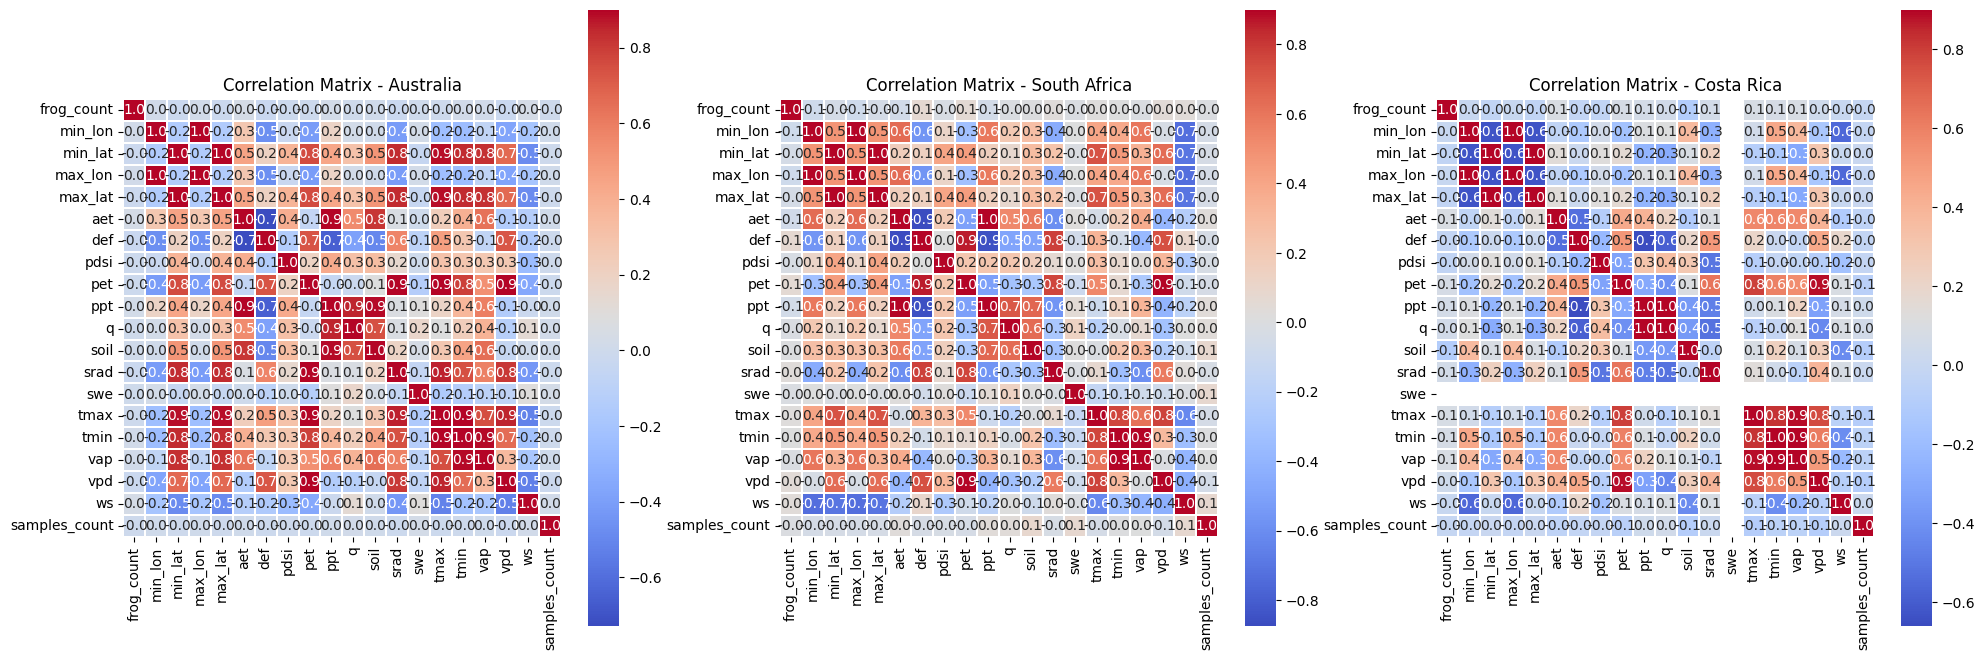

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrices for each region
corr_matrix_aus = train_data_aus.corr()
corr_matrix_sa = train_data_sa.corr()
corr_matrix_cr = train_data_cr.corr()

# Set up the plot
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot Australia correlation matrix
sns.heatmap(corr_matrix_aus, ax=axes[0], vmax=0.9, square=True, annot=True, linewidths=0.3, cmap="coolwarm", fmt=".1f")
axes[0].set_title('Correlation Matrix - Australia')

# Plot South Africa correlation matrix
sns.heatmap(corr_matrix_sa, ax=axes[1], vmax=0.9, square=True, annot=True, linewidths=0.3, cmap="coolwarm", fmt=".1f")
axes[1].set_title('Correlation Matrix - South Africa')

# Plot Croatia correlation matrix
sns.heatmap(corr_matrix_cr, ax=axes[2], vmax=0.9, square=True, annot=True, linewidths=0.3, cmap="coolwarm", fmt=".1f")
axes[2].set_title('Correlation Matrix - Costa Rica')

# Show the plot
plt.show()


Indentifying Outliers

In [ ]:
num_col = ['aet', 'def', 'pdsi', 'pet', 'ppt', 'q', 'soil', 'srad', 'swe', 'tmax',
       'tmin', 'vap', 'vpd', 'ws']

In [ ]:
out_per=[]
for i in num_col:
    data_mean, data_std = mean(train_data_aus[i]), std(train_data_aus[i])
# identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    print(i,': \n')
# identify outliers
    outliers = [x for x in train_data_aus[i] if x < lower or x > upper]

    num_out=len(outliers)
    print('Identified outliers: %d' % num_out)
    outliers_removed = [x for x in train_data_aus[i] if x >= lower and x <= upper]
    num_nout=len(outliers_removed)
    print('Non-outlier observations: %d' % num_nout)
    print('\n')

Checking distribution of columns with missing vales

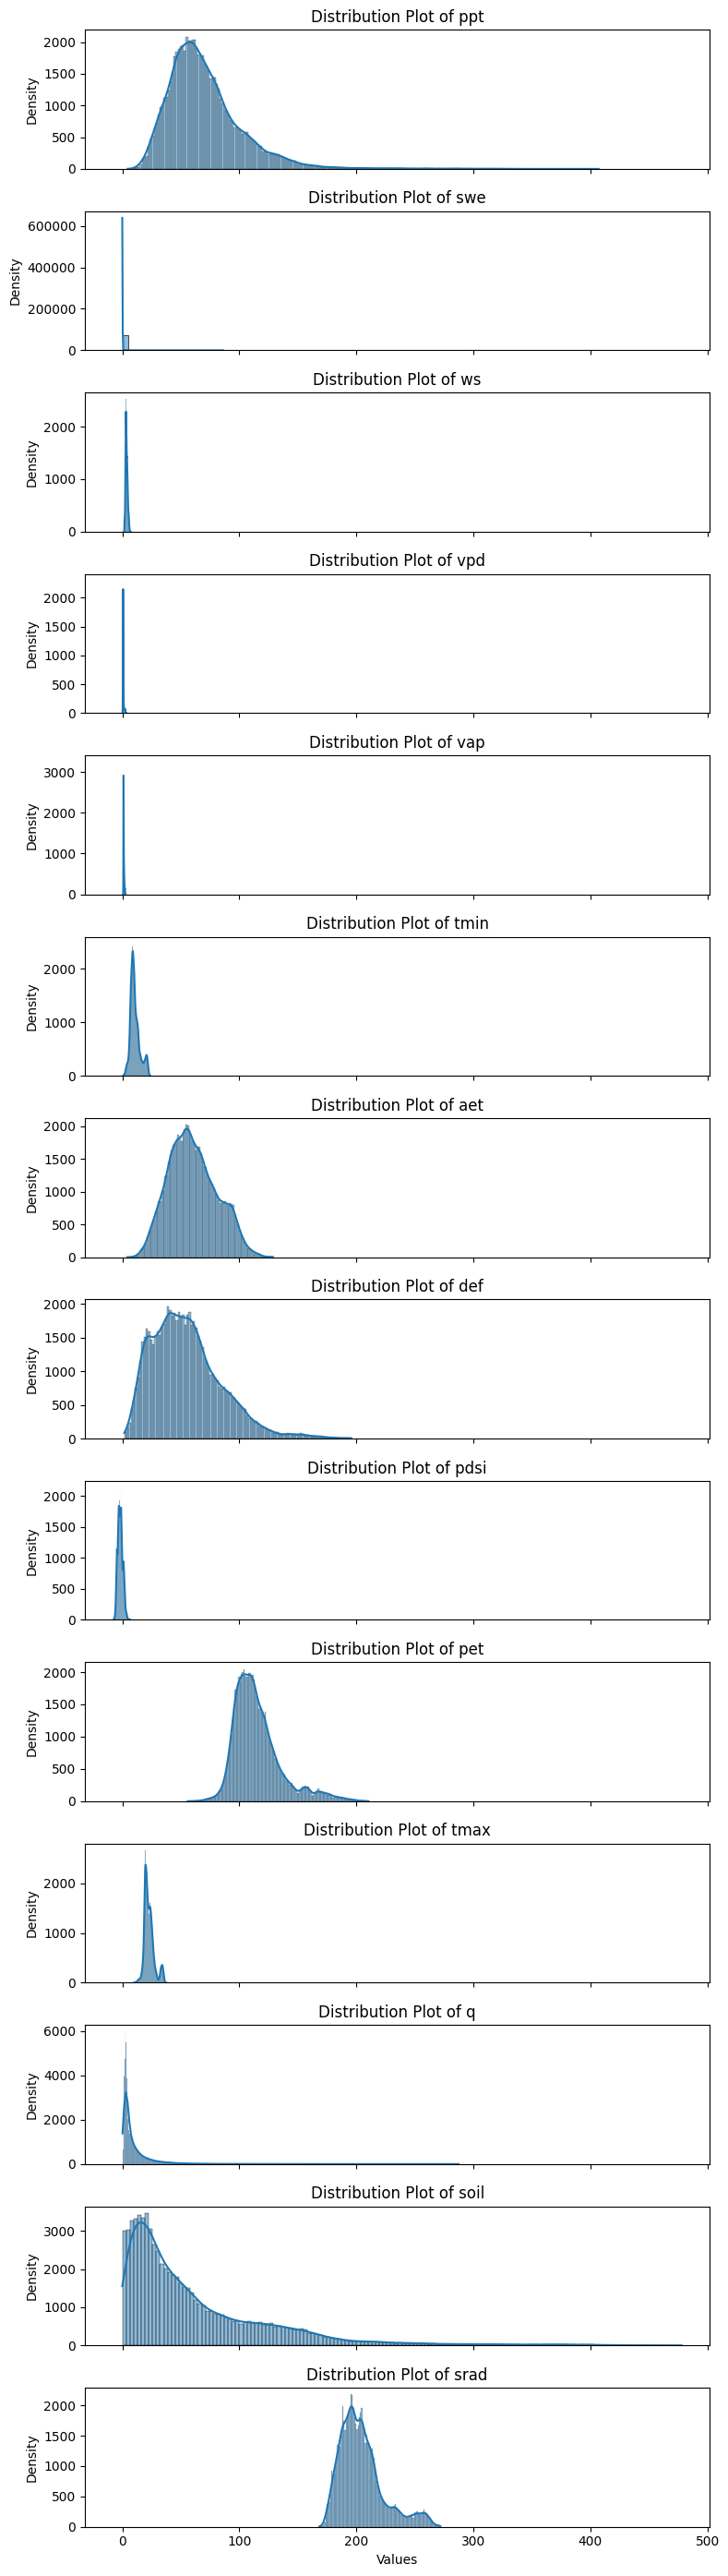

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

train_data_aus_reset = train_data_aus.reset_index(drop=True)

# List of column names
columns = ['ppt', 'swe', 'ws', 'vpd', 'vap', 'tmin', 'aet', 'def', 'pdsi', 'pet', 'tmax', 'q', 'soil', 'srad']

# Calculate the number of rows and columns for the subplot grid
num_rows = len(columns)
num_cols = 1

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 2*num_rows), sharex=True)

# Plot distribution plots for each column
for i, column in enumerate(columns):
    sns.histplot(data=train_data_aus_reset, x=column, ax=axes[i], kde=True)
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Distribution Plot of {column}')

# Add x-axis label to the last subplot
axes[-1].set_xlabel('Values')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



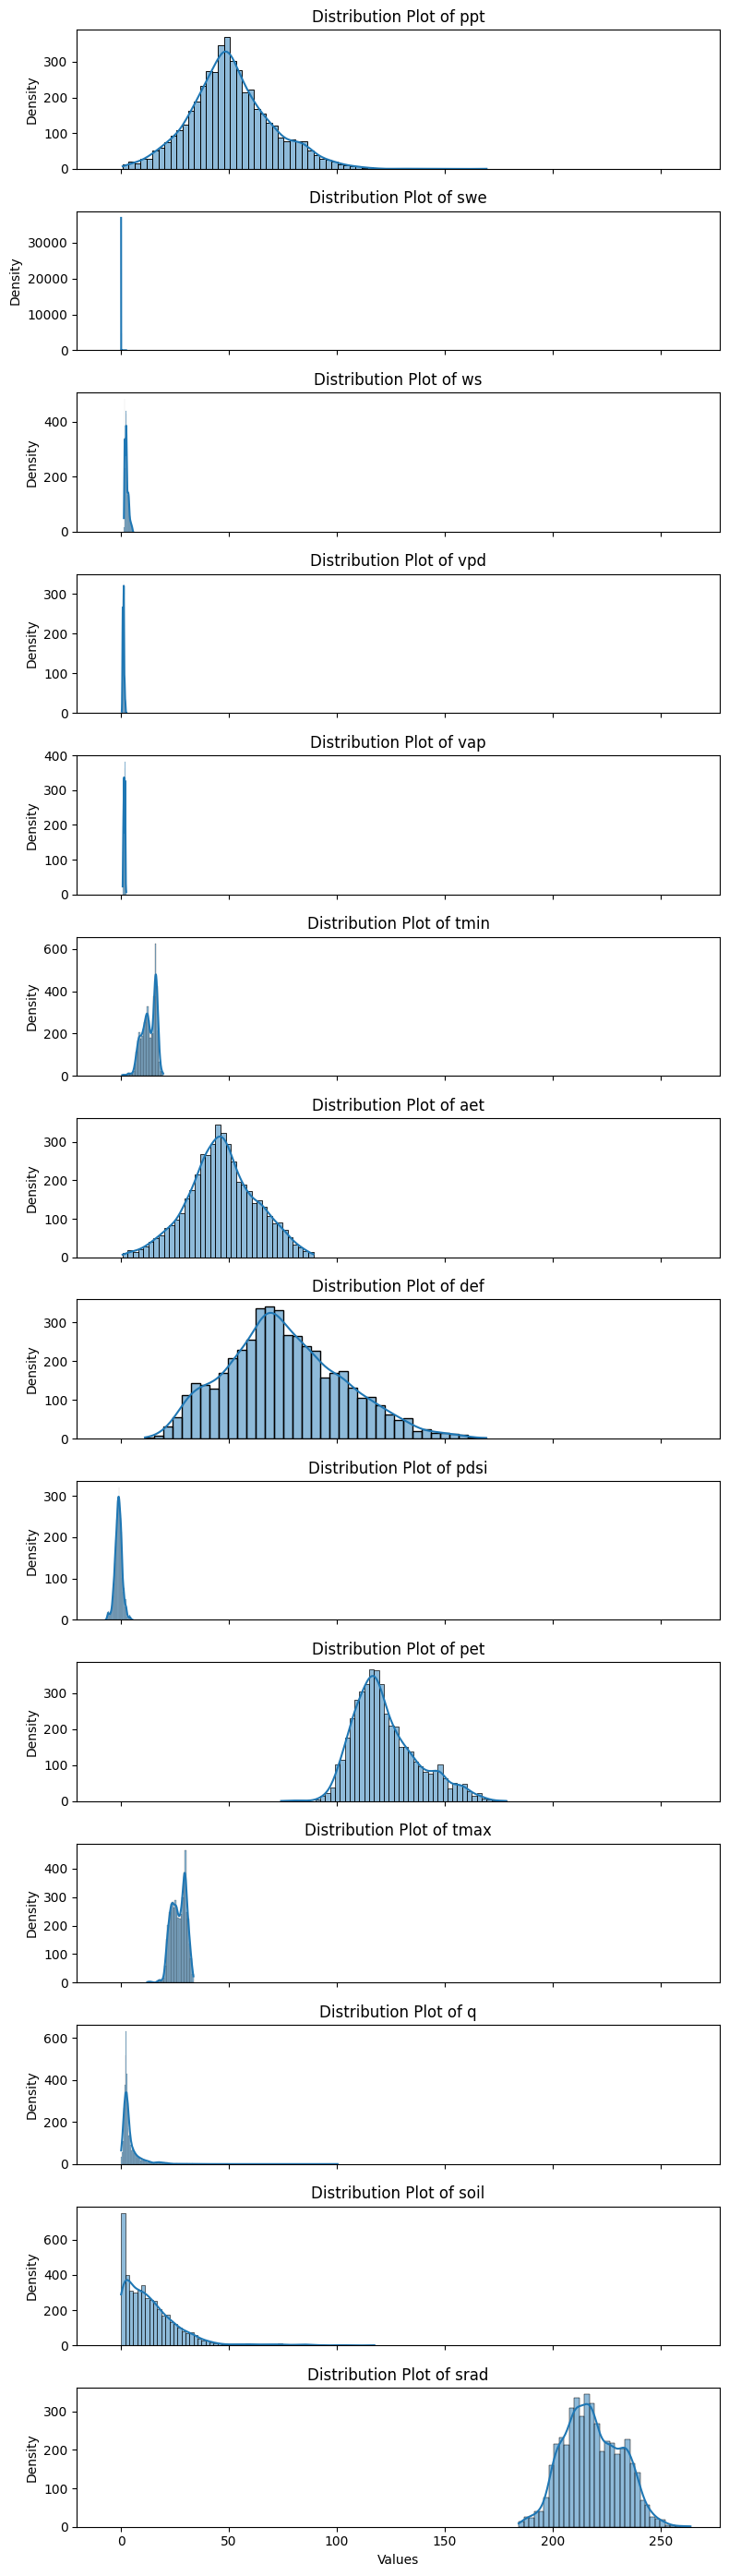

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

train_data_sa_reset = train_data_sa.reset_index(drop=True)

# List of column names
columns = ['ppt', 'swe', 'ws', 'vpd', 'vap', 'tmin', 'aet', 'def', 'pdsi', 'pet', 'tmax', 'q', 'soil', 'srad']

# Calculate the number of rows and columns for the subplot grid
num_rows = len(columns)
num_cols = 1

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 2*num_rows), sharex=True)

# Plot distribution plots for each column
for i, column in enumerate(columns):
    sns.histplot(data=train_data_sa_reset, x=column, ax=axes[i], kde=True)
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Distribution Plot of {column}')

# Add x-axis label to the last subplot
axes[-1].set_xlabel('Values')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



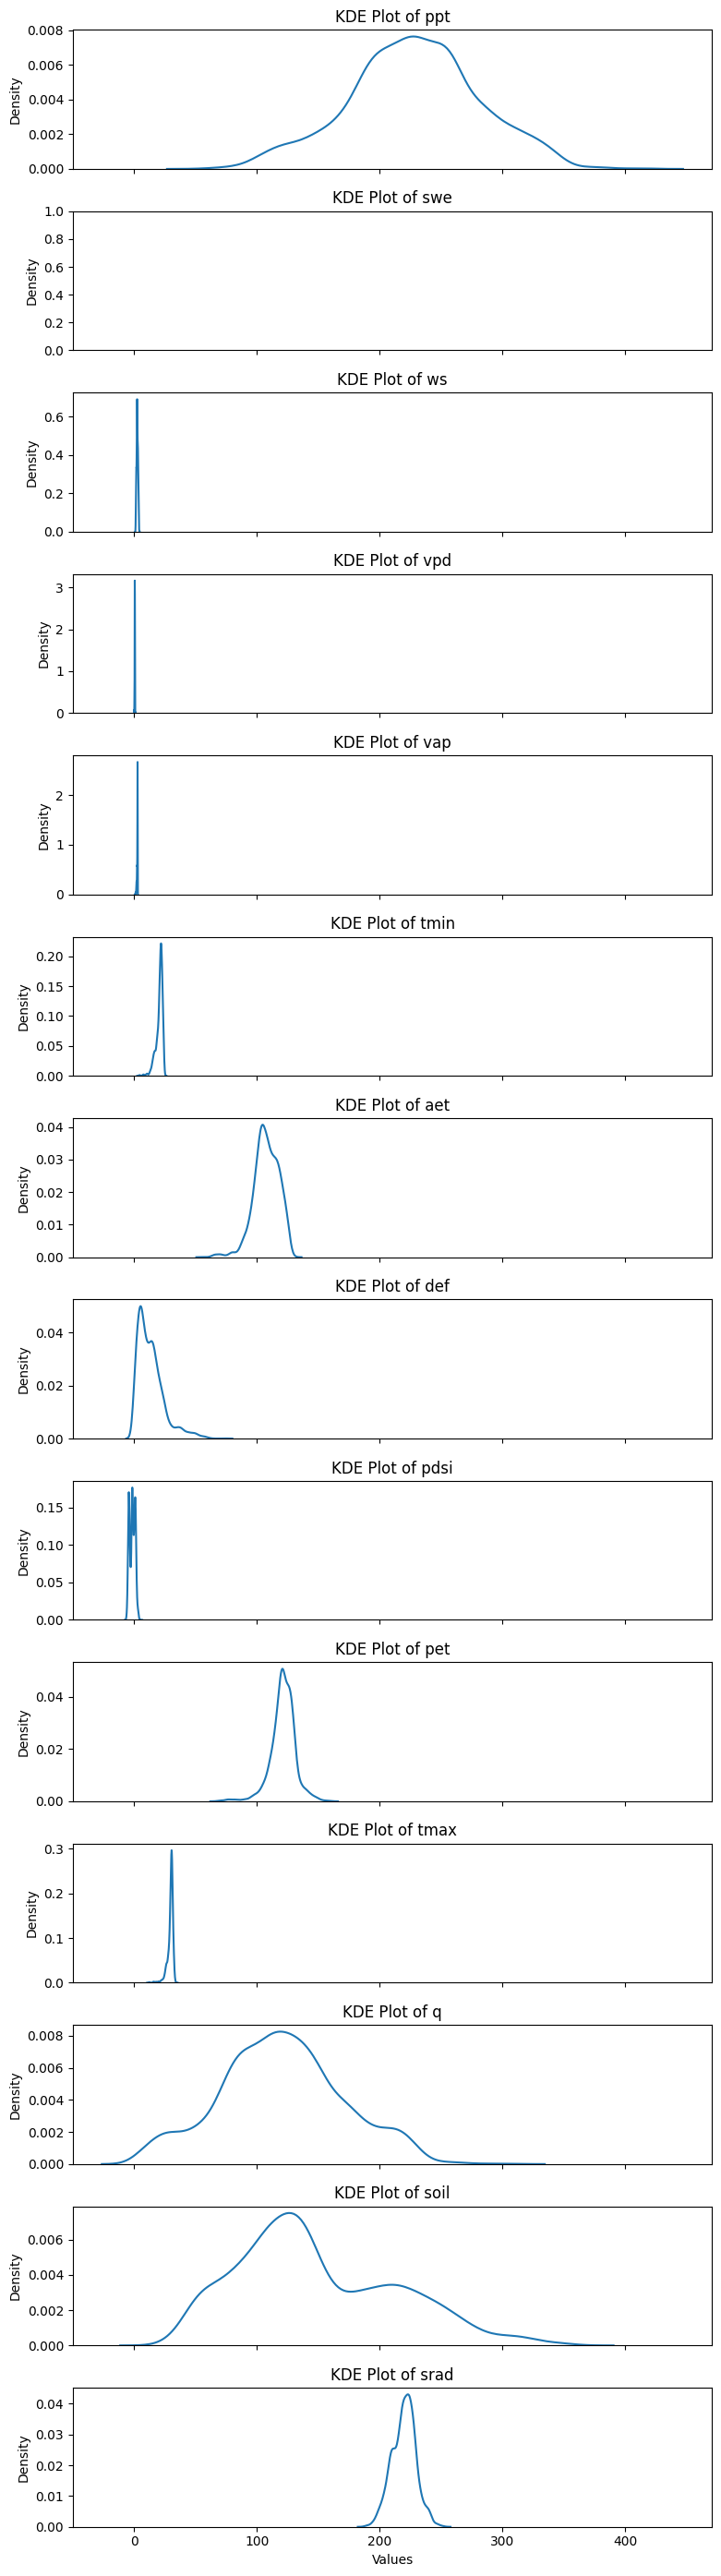

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

train_data_cr_reset = train_data_cr.reset_index(drop=True)

# List of column names
columns = ['ppt', 'swe', 'ws', 'vpd', 'vap', 'tmin', 'aet', 'def', 'pdsi', 'pet', 'tmax', 'q', 'soil', 'srad']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(8, 2*len(columns)), sharex=True)

# Plot KDE plots for each column
for i, column in enumerate(columns):
    sns.kdeplot(data=train_data_cr_reset, x=column, ax=axes[i])
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'KDE Plot of {column}')

# Add x-axis label to the last subplot
axes[-1].set_xlabel('Values')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



If the data has a right-skewed distribution, meaning it has a long tail on the right side, the best imputation method would generally be the median.

The median is less sensitive to extreme values and outliers compared to the mean. In right-skewed data, the mean can be pulled towards the right by the presence of large values in the tail, making it less representative of the central tendency of the data. On the other hand, the median is the middle value of the dataset when arranged in ascending order, so it is not affected by extreme values in the tail and gives a more robust estimate of the central value.

By using the median for imputation in right-skewed data, you are less likely to introduce bias in your analysis due to the influence of extreme values. This is particularly important when dealing with datasets that have a large number of missing values or when the missing values are related to the right-skewed nature of the data.

Data Visualisations

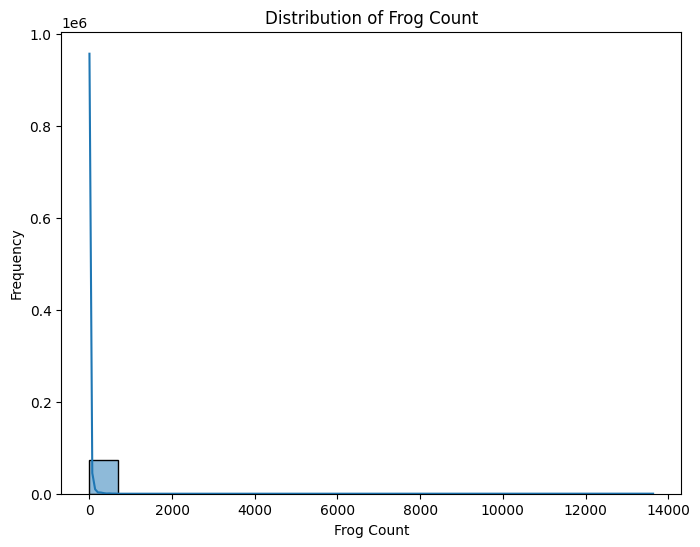

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_data_aus, x='frog_count', bins=20, kde=True)
plt.xlabel('Frog Count')
plt.ylabel('Frequency')
plt.title('Distribution of Frog Count')
plt.show()


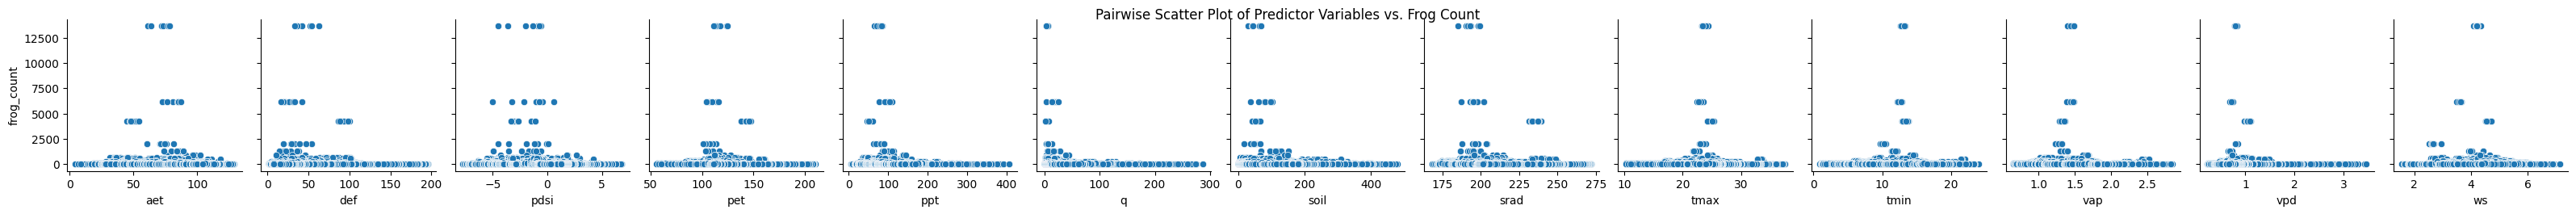

In [ ]:
sns.pairplot(train_data_aus, x_vars=['aet', 'def', 'pdsi', 'pet', 'ppt', 'q', 'soil', 'srad', 'tmax', 'tmin', 'vap', 'vpd', 'ws'], y_vars=['frog_count'], diag_kind='kde')
plt.suptitle('Pairwise Scatter Plot of Predictor Variables vs. Frog Count', y=1.02)
plt.show()


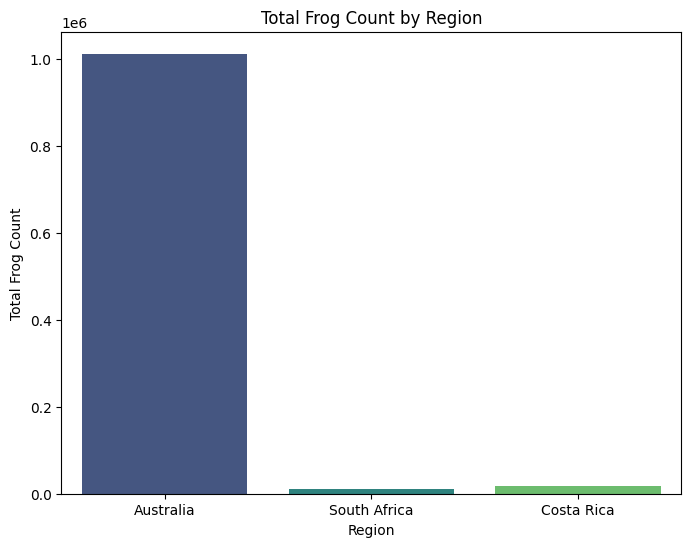

In [ ]:
total_frog_count = [aus_train['frog_count'].sum(), sa_train['frog_count'].sum(), cr_train['frog_count'].sum()]
regions = ['Australia', 'South Africa', 'Costa Rica']

plt.figure(figsize=(8, 6))
sns.barplot(x=regions, y=total_frog_count, palette='viridis')
plt.xlabel('Region')
plt.ylabel('Total Frog Count')
plt.title('Total Frog Count by Region')
plt.show()

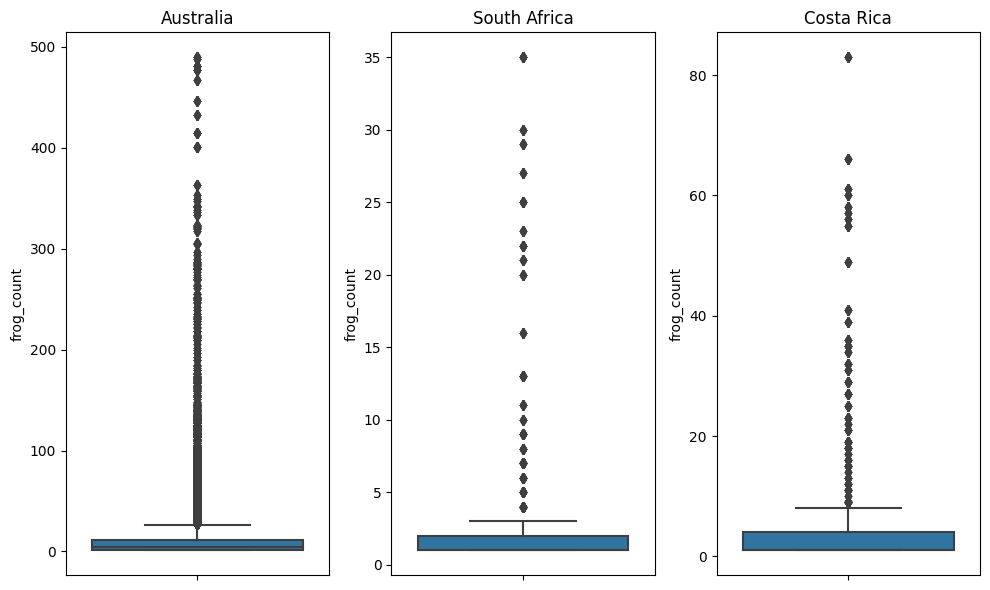

In [ ]:
plt.figure(figsize=(10, 6))

# Australia
plt.subplot(1, 3, 1)
sns.boxplot(data=aus_train, y='frog_count')
plt.title('Australia')

# South Africa
plt.subplot(1, 3, 2)
sns.boxplot(data=sa_train, y='frog_count')
plt.title('South Africa')

# Costa Rica
plt.subplot(1, 3, 3)
sns.boxplot(data=cr_train, y='frog_count')
plt.title('Costa Rica')

plt.tight_layout()
plt.show()


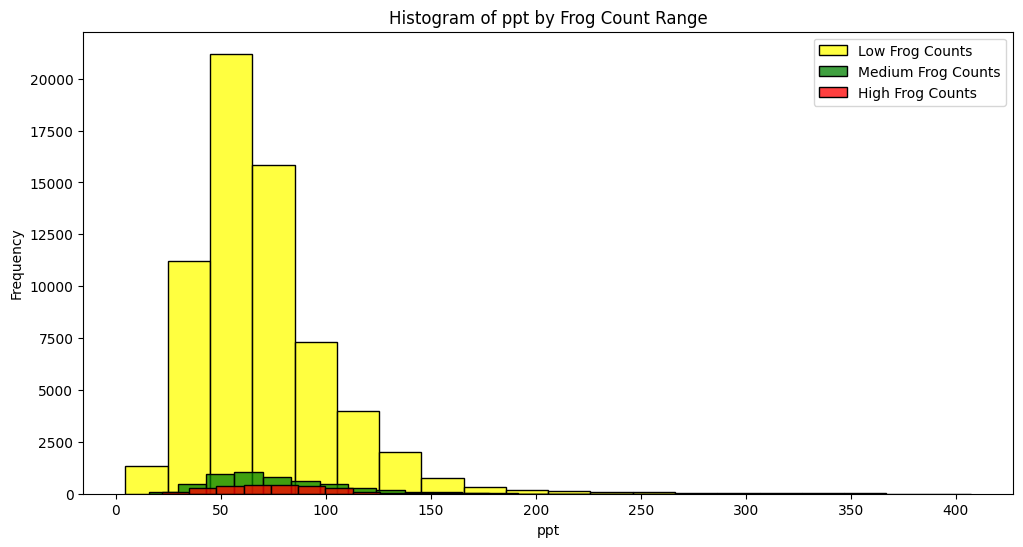

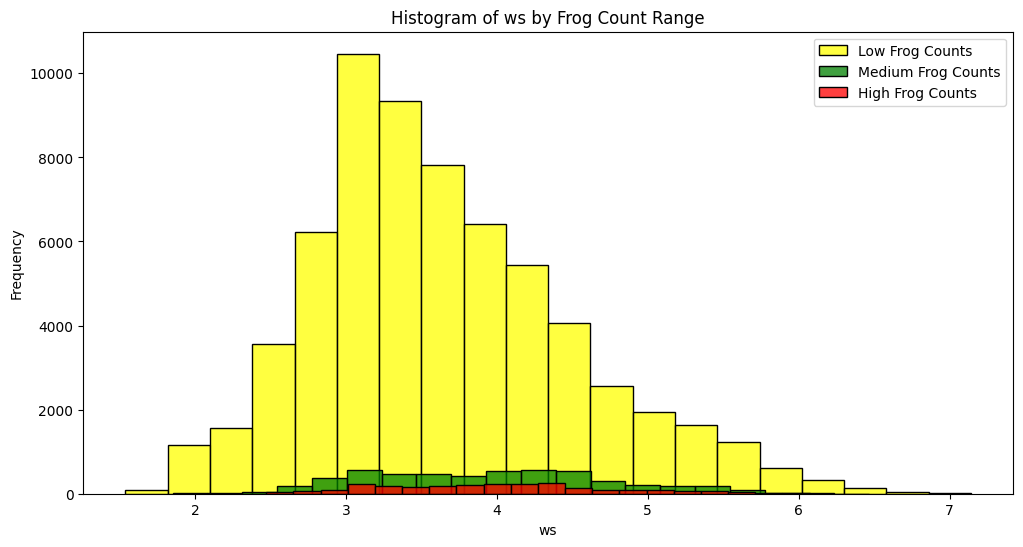

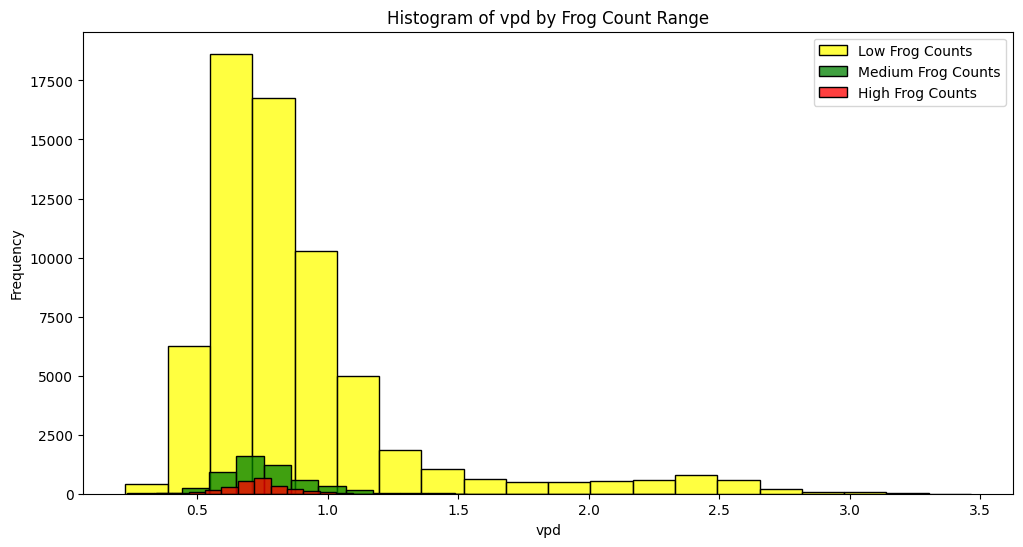

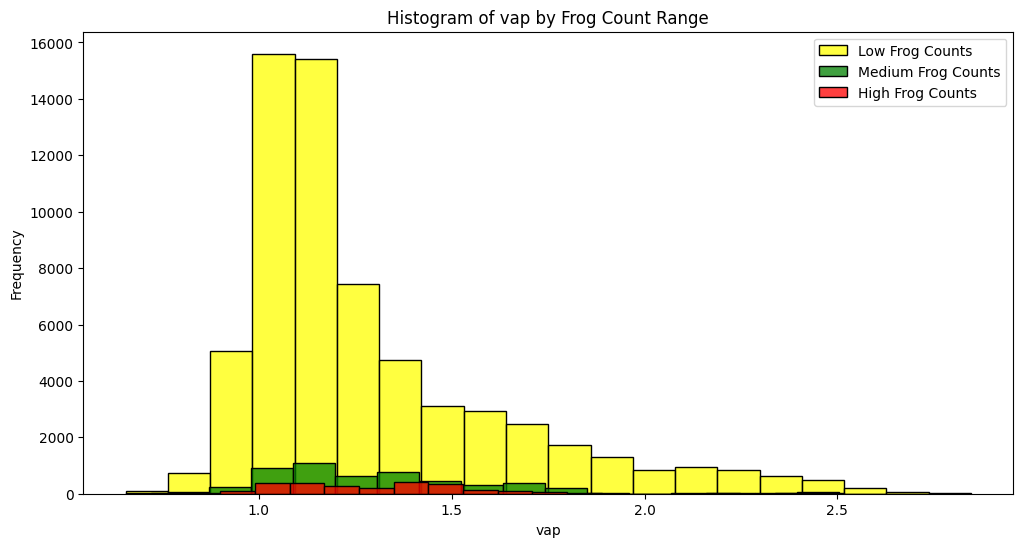

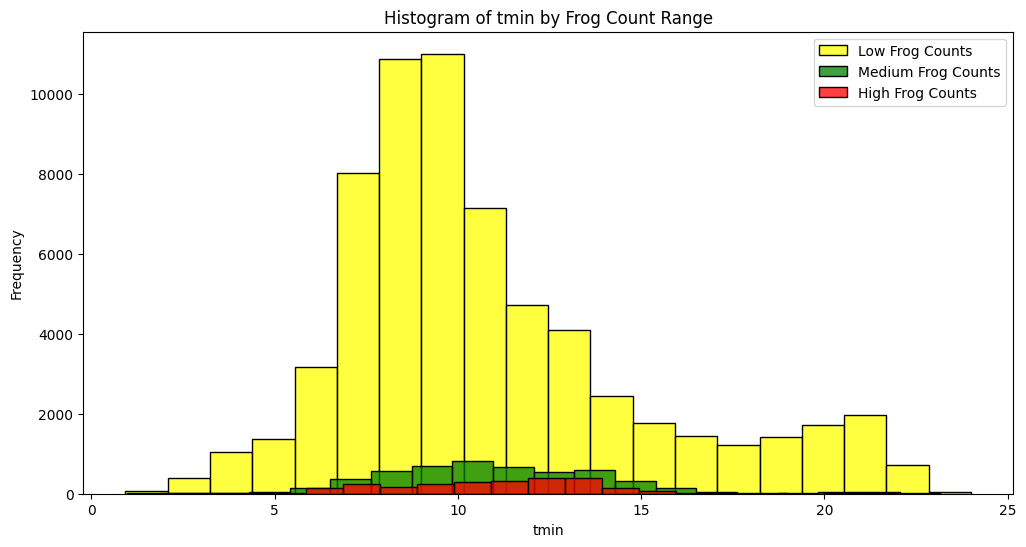

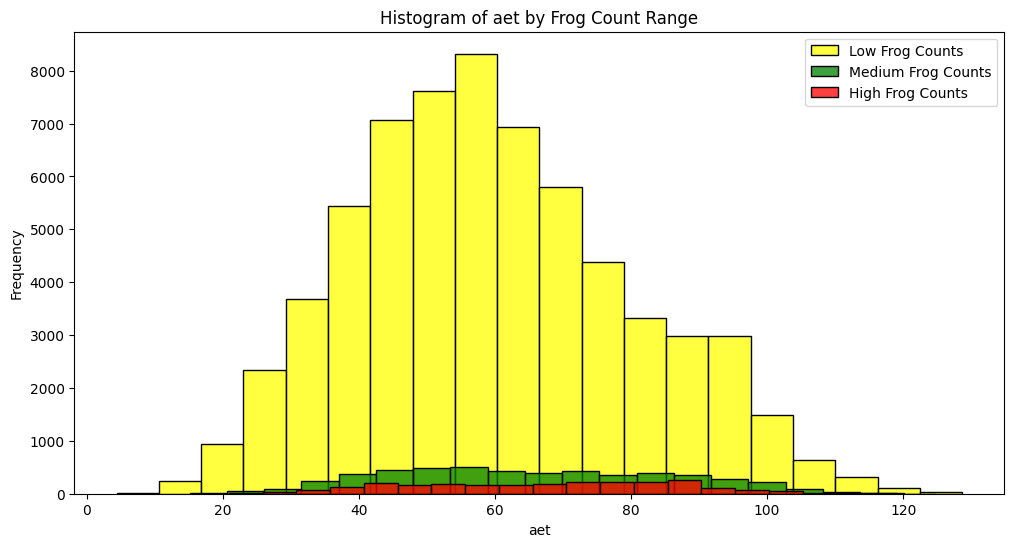

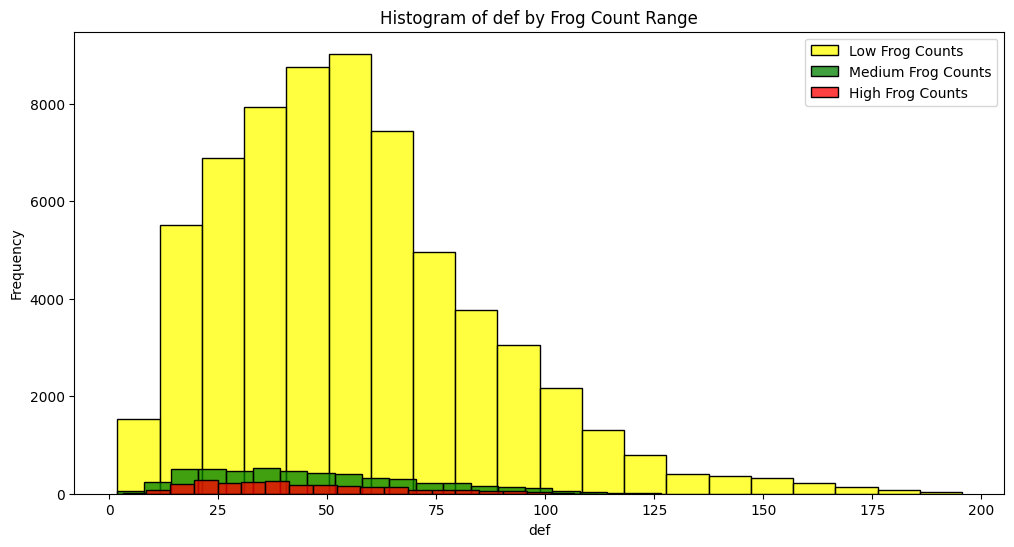

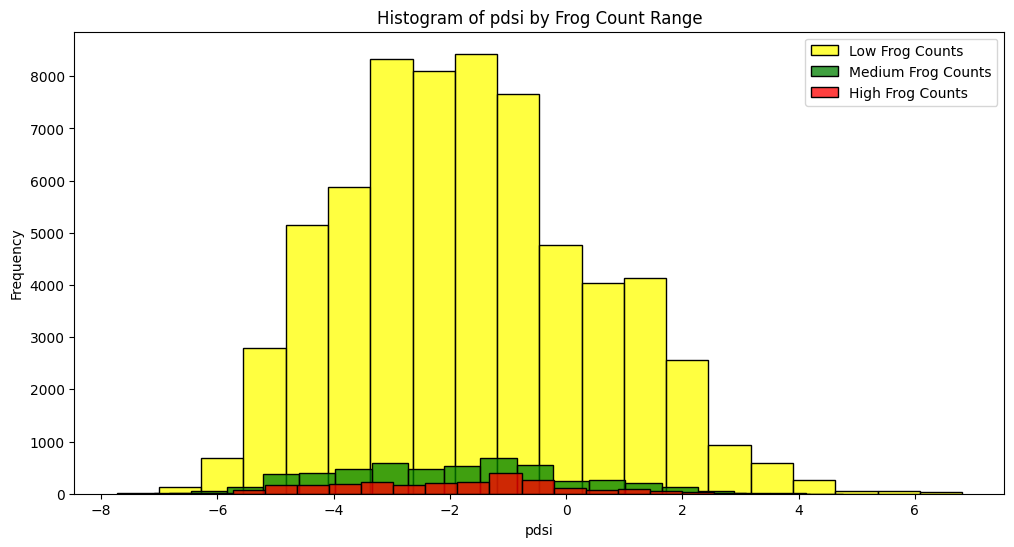

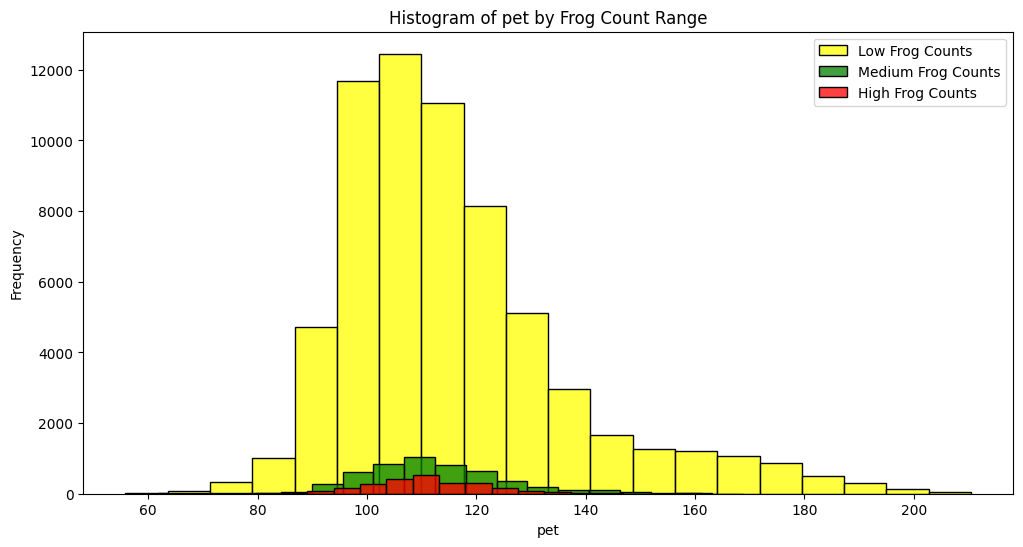

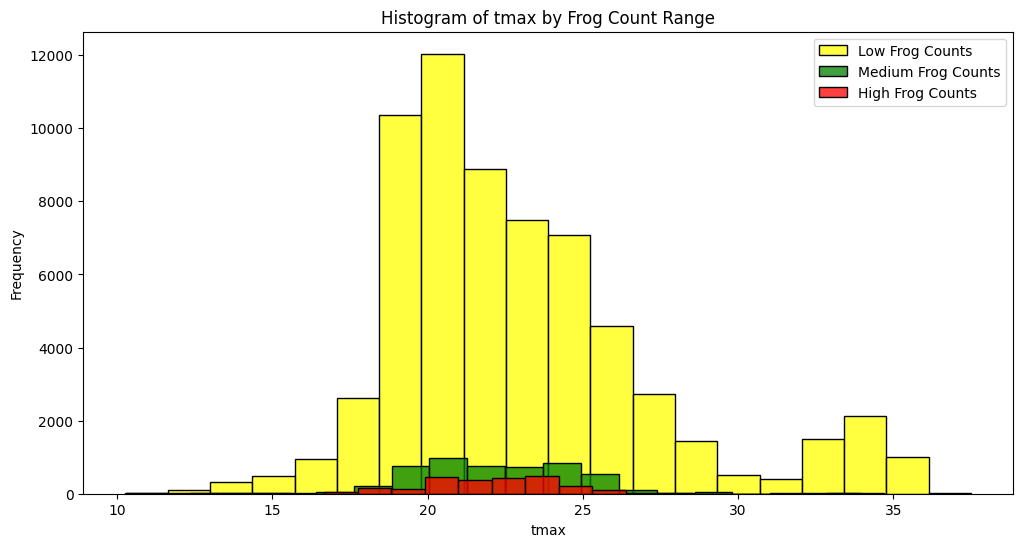

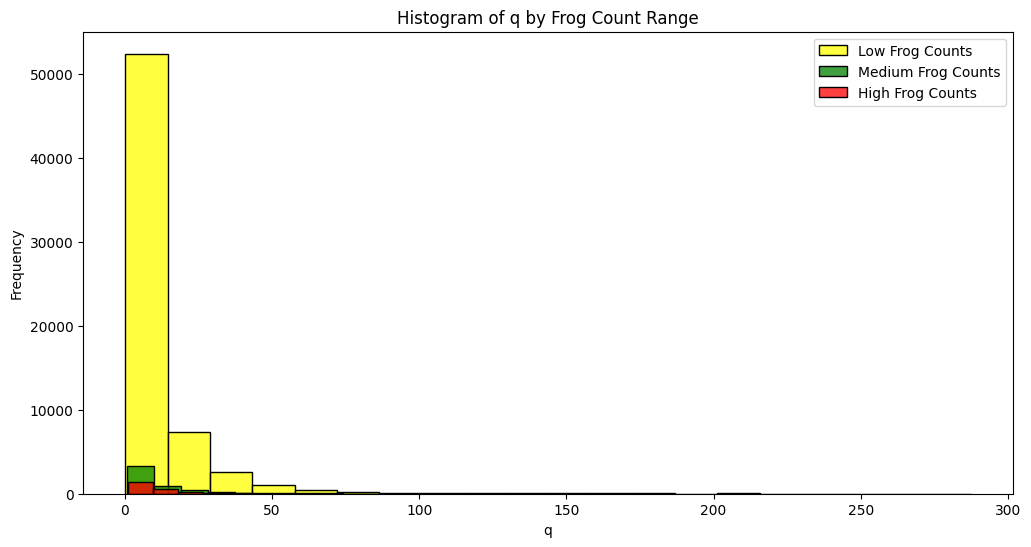

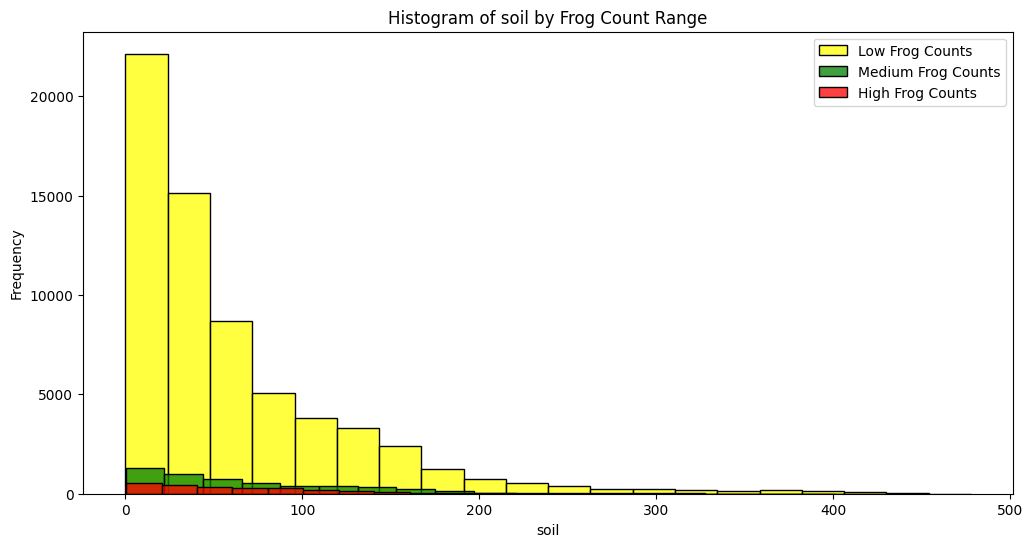

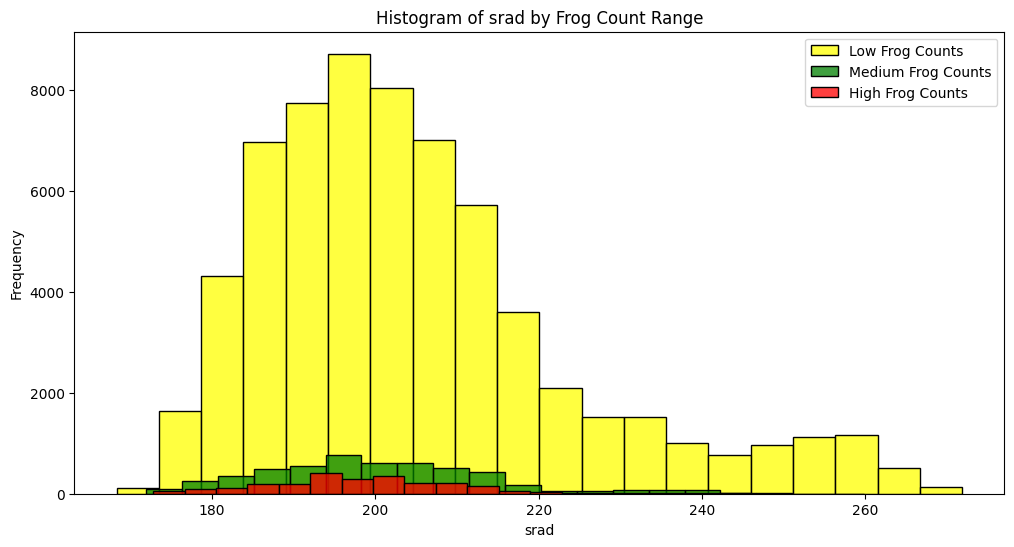

In [ ]:
# Define the ranges for frog counts
low_counts = aus_train[aus_train['frog_count'] < 30]
medium_counts = aus_train[(aus_train['frog_count'] >= 30) & (aus_train['frog_count'] <= 80)]
high_counts = aus_train[aus_train['frog_count'] > 80]


# List of weather variables
weather_vars = ['ppt',  'ws', 'vpd', 'vap', 'tmin', 'aet', 'def', 'pdsi', 'pet', 'tmax', 'q', 'soil', 'srad']
names = []
# Create histograms for each weather variable in different frog count ranges
for var in weather_vars:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=low_counts, x=var, bins=20, color='yellow', label='Low Frog Counts')
    sns.histplot(data=medium_counts, x=var, bins=20, color='green', label='Medium Frog Counts')
    sns.histplot(data=high_counts, x=var, bins=20, color='red', label='High Frog Counts')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {var} by Frog Count Range')
    plt.legend()
    plt.show()


In [ ]:
# Define the ranges for frog counts
low_counts = sa_train[sa_train['frog_count'] < 30]
medium_counts = sa_train[(sa_train['frog_count'] >= 30) & (sa_train['frog_count'] <= 80)]
high_counts = sa_train[sa_train['frog_count'] > 80]


# List of weather variables
weather_vars = ['ppt',  'ws', 'vpd', 'vap', 'tmin', 'aet', 'def', 'pdsi', 'pet', 'tmax', 'q', 'soil', 'srad']
names = []
# Create histograms for each weather variable in different frog count ranges
for var in weather_vars:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=low_counts, x=var, bins=20, color='yellow', label='Low Frog Counts')
    sns.histplot(data=medium_counts, x=var, bins=20, color='green', label='Medium Frog Counts')
    sns.histplot(data=high_counts, x=var, bins=20, color='red', label='High Frog Counts')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {var} by Frog Count Range')
    plt.legend()
    plt.show()


In [ ]:
# Define the ranges for frog counts
low_counts = cr_train[cr_train['frog_count'] < 30]
medium_counts = cr_train[(cr_train['frog_count'] >= 30) & (cr_train['frog_count'] <= 80)]
high_counts = cr_train[cr_train['frog_count'] > 80]


# List of weather variables
weather_vars = ['ppt',  'ws', 'vpd', 'vap', 'tmin', 'aet', 'def', 'pdsi', 'pet', 'tmax', 'q', 'soil', 'srad']
names = []
# Create histograms for each weather variable in different frog count ranges
for var in weather_vars:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=low_counts, x=var, bins=20, color='yellow', label='Low Frog Counts')
    sns.histplot(data=medium_counts, x=var, bins=20, color='green', label='Medium Frog Counts')
    sns.histplot(data=high_counts, x=var, bins=20, color='red', label='High Frog Counts')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {var} by Frog Count Range')
    plt.legend()
    plt.show()


# Data Preprocessing

Feature Engineering - Generating Features from the existing data

Calculating Temperature Difference

In [ ]:
aus_train["tmax_tmin_diff"] = aus_train["tmax"] - aus_train["tmin"]
sa_train["tmax_tmin_diff"] = sa_train["tmax"] - sa_train["tmin"]
cr_train["tmax_tmin_diff"] = cr_train["tmax"] - cr_train["tmin"]

Predictor Variables

Predictor variable, also known sometimes as the independent variable, is used to make a prediction for dependent variables. Predictor variables are extremely common in data science and the scientific method. The predictor variable is the counterpart to the dependent variable, often directly informed or affected by the predictor variable.

In [ ]:
aus_train.head()

,aet,def,pdsi,pet,ppt,q,soil,srad,tmax,tmin,vap,vpd,ws,frog_count,tmax_tmin_diff
0,26.064001,134.459991,-4.060000,160.524017,27.808,1.380,20.275999,240.172623,27.247997,13.992002,1.50364,1.1656,5.236400,2,13.255996
1,61.523998,60.476006,-4.372000,122.000000,65.944,8.292,123.384003,226.955383,21.555998,12.859999,1.35048,0.7000,5.690000,1,8.695999
2,60.212002,62.871998,-4.447999,123.083992,63.664,7.716,117.872002,227.848190,21.716002,12.895999,1.35752,0.7080,5.716000,1,8.820003
3,58.345003,50.997997,-1.828300,111.105999,64.540,4.758,40.009001,200.920036,21.987802,9.879999,1.16998,0.7624,3.535000,1,12.107802
4,58.267998,55.727997,-3.784000,113.996002,69.592,14.428,94.989998,223.156128,20.631996,13.242001,1.37250,0.6354,5.655799,3,7.389996


In [ ]:
sa_train.head()

,aet,def,pdsi,pet,ppt,q,soil,srad,tmax,tmin,vap,vpd,ws,frog_count,tmax_tmin_diff
0,10.763996,148.844009,-0.874000,159.608002,11.322,0.558,0.100,229.190002,28.675997,16.773998,1.13180,1.8634,2.925000,2,11.901999
1,1.880000,115.114006,2.844000,116.994011,1.974,0.094,0.000,214.908142,24.209999,13.464003,1.54996,0.8104,3.893200,1,10.745996
2,11.941999,153.444000,-1.344000,165.385971,12.566,0.626,0.222,240.654449,31.833996,15.132001,1.11848,2.1746,2.570600,1,16.701995
3,2.454000,154.360016,-3.725999,156.814011,2.580,0.128,0.000,236.593842,27.915993,14.098001,0.97998,1.8200,2.915800,3,13.817992
4,7.108000,137.376007,-3.328000,144.484009,7.476,0.368,0.100,244.491638,23.840002,8.427999,0.73468,1.3968,3.038801,2,15.412003


In [ ]:
cr_train.head()

,aet,def,pdsi,pet,ppt,q,soil,srad,tmax,tmin,vap,vpd,ws,frog_count,tmax_tmin_diff
0,98.976006,16.271999,-1.680,115.248009,128.068,29.088,125.856018,228.407562,26.380003,15.587998,1.98916,0.6572,1.9004,6,10.792005
1,106.740013,17.844000,-1.162,124.584015,125.026,23.792,114.659988,228.137695,30.740000,21.239998,2.71726,0.8152,1.6340,1,9.500002
2,113.790009,15.174000,-1.238,128.963989,140.786,31.510,120.914001,227.960403,31.553999,22.862000,2.87956,0.8916,1.7910,2,8.691999
3,100.442009,27.449997,-2.048,127.891998,126.736,29.554,132.538010,239.341888,29.077995,17.418001,2.10642,0.9206,1.6314,4,11.659994
4,107.829987,11.357999,-1.299,121.612000,227.816,119.140,135.238022,220.247604,30.270996,21.453798,2.83156,0.6528,2.6338,2,8.817198


In [ ]:
# Concatenate the datasets
all_train = pd.concat([aus_train, sa_train, cr_train], ignore_index=True)

# Separate target variable
target = all_train['frog_count']
all_train.drop(columns=['frog_count'], inplace=True)

# Display the scaled dataset
print(all_train.head())


         aet         def      pdsi         pet     ppt       q        soil  \
0  26.064001  134.459991 -4.060000  160.524017  27.808   1.380   20.275999   
1  61.523998   60.476006 -4.372000  122.000000  65.944   8.292  123.384003   
2  60.212002   62.871998 -4.447999  123.083992  63.664   7.716  117.872002   
3  58.345003   50.997997 -1.828300  111.105999  64.540   4.758   40.009001   
4  58.267998   55.727997 -3.784000  113.996002  69.592  14.428   94.989998   

         srad       tmax       tmin      vap     vpd        ws  tmax_tmin_diff  
0  240.172623  27.247997  13.992002  1.50364  1.1656  5.236400       13.255996  
1  226.955383  21.555998  12.859999  1.35048  0.7000  5.690000        8.695999  
2  227.848190  21.716002  12.895999  1.35752  0.7080  5.716000        8.820003  
3  200.920036  21.987802   9.879999  1.16998  0.7624  3.535000       12.107802  
4  223.156128  20.631996  13.242001  1.37250  0.6354  5.655799        7.389996  


In [ ]:
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_train, target, test_size=0.2, random_state=2022)

In [ ]:
#Initialize MinMaxScaler
mm_scaler = MinMaxScaler()

#Apply MinMaxScaler to the features
all_train_scaled = mm_scaler.fit_transform(all_train)

#Convert back to DataFrame
all_train_scaled = pd.DataFrame(all_train_scaled, columns=all_train.columns)

X_train_mm, X_test_mm, y_train, y_test = train_test_split(all_train_scaled, target, test_size=0.2, random_state=2022)

#Model Implementation, Hyperparameter Tuning and Results

In [ ]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Embedding, SimpleRNN
from keras.losses import MSE
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from datetime import datetime
import os
import random
import gc
import warnings
from hyperopt import hp
import hyperopt.pyll.stochastic
from hyperopt import fmin, tpe, hp, STATUS_OK
from sklearn.model_selection  import train_test_split
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Filter out specific warning categories
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


### Light GBM Implementation

In [ ]:
#Defining paramaters to be iterated over
parameter_bounds = {
    'learning_rate': (0.002, 0.35),
    'num_leaves': (30, 600),
    'bagging_fraction' : (0.1, 1),
    'feature_fraction' : (0.1, 1),
}

In [ ]:
def lgbm_optimise(learning_rate,
                num_leaves,
                bagging_fraction,
                feature_fraction, ):

    params = {'learning_rate': learning_rate,
              'num_leaves': int(num_leaves),
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'objective': 'regression',
              'boosting_type': 'gbdt',
              'random_state': 47,
              'verbosity': 0,
              'metric': 'rmse'}

    train_data = lgb.Dataset(X_train, y_train)
    validation_data = lgb.Dataset(X_test, y_test)
    model = lgb.train(params, train_data, 5000, valid_sets = [train_data, validation_data])
    # Returning negative rmse because optimizer tries to maximize a function
    return -model.best_score['valid_1']['rmse']

In [ ]:
# Finding hyperparameters using bayesian optimization
optimizer = BayesianOptimization(f=lgbm_optimise, pbounds=parameter_bounds, random_state=47)
optimizer.maximize(init_points=10, n_iter=5)

In [ ]:
print(optimizer.max['params'])

{'bagging_fraction': 0.1, 'feature_fraction': 1.0, 'learning_rate': 0.002, 'num_leaves': 40.493648181553446}


In [ ]:
opti_params = {'learning_rate': 0.002,
              'num_leaves': int(41),
              'bagging_fraction' : 0.1,
              'feature_fraction' : 1,
              'objective': 'regression',
              'boosting_type': 'gbdt',
              'random_state': 47,
              'verbosity': 0,
              'metric': 'rmse'}

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032017 seconds.
You can set `force_col_wise=true` to remove the overhead.


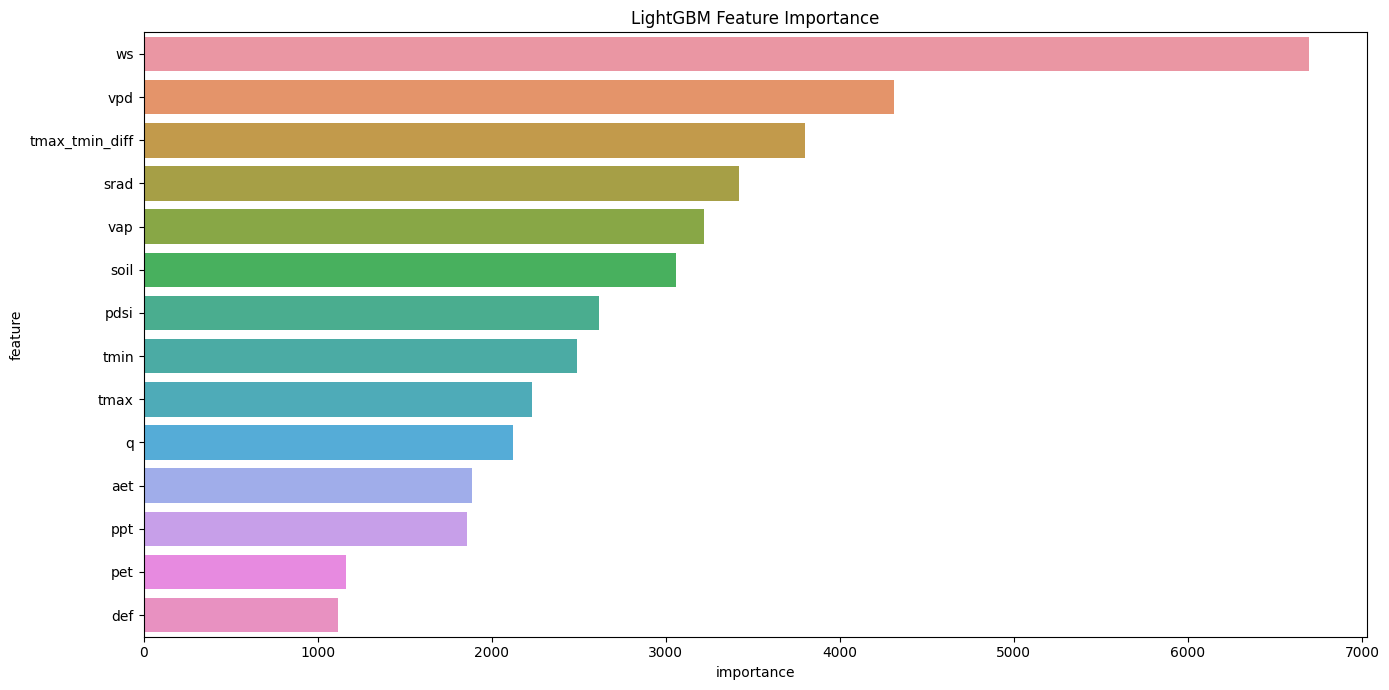

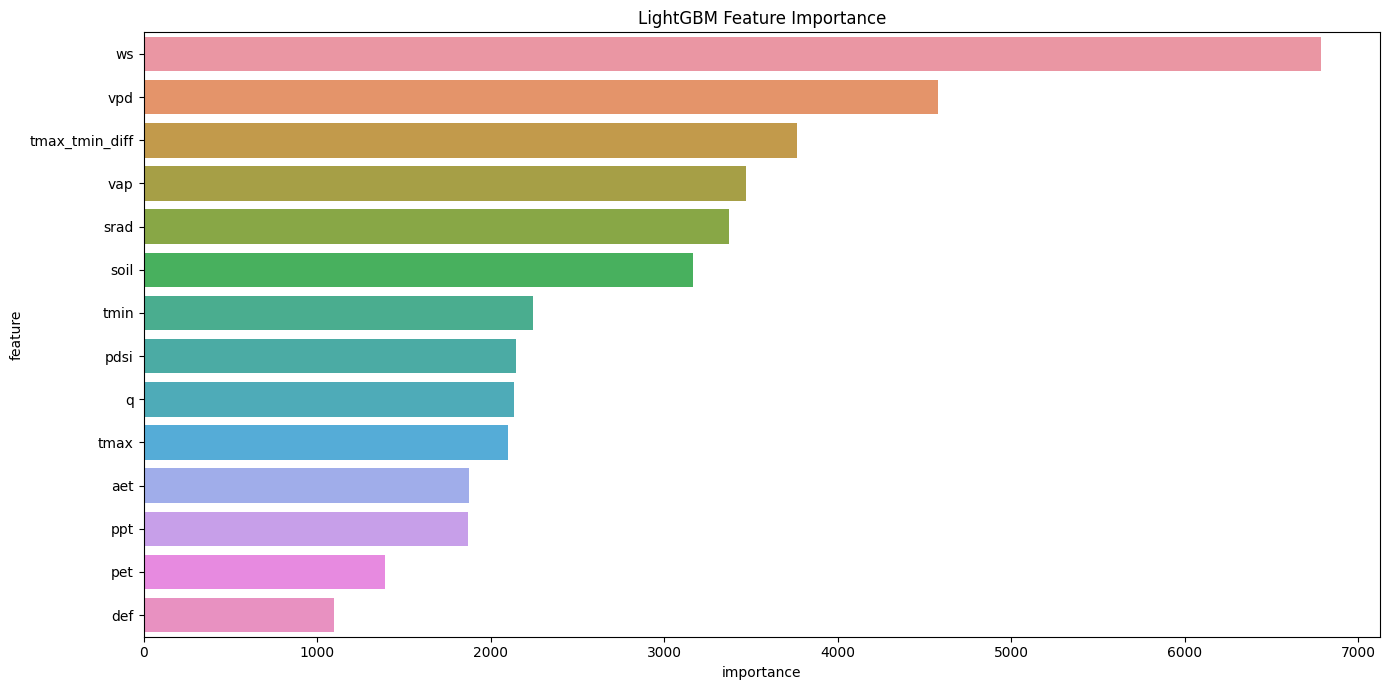

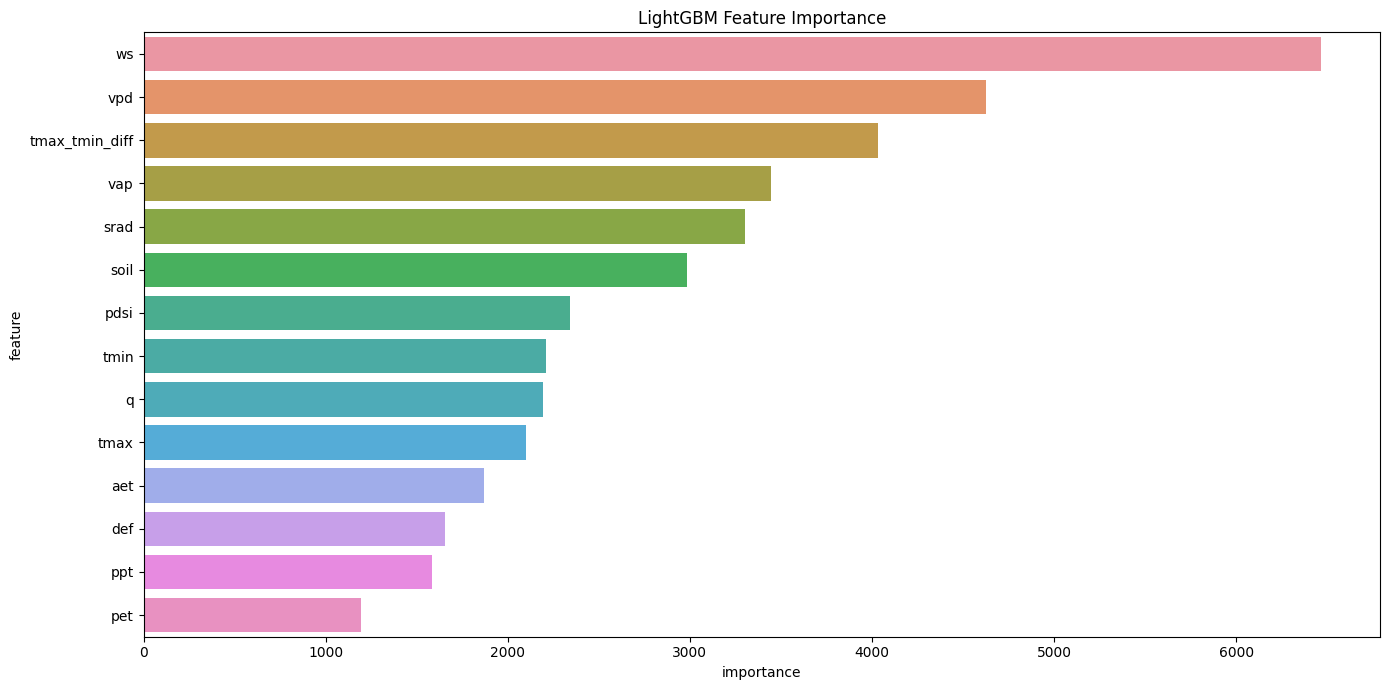

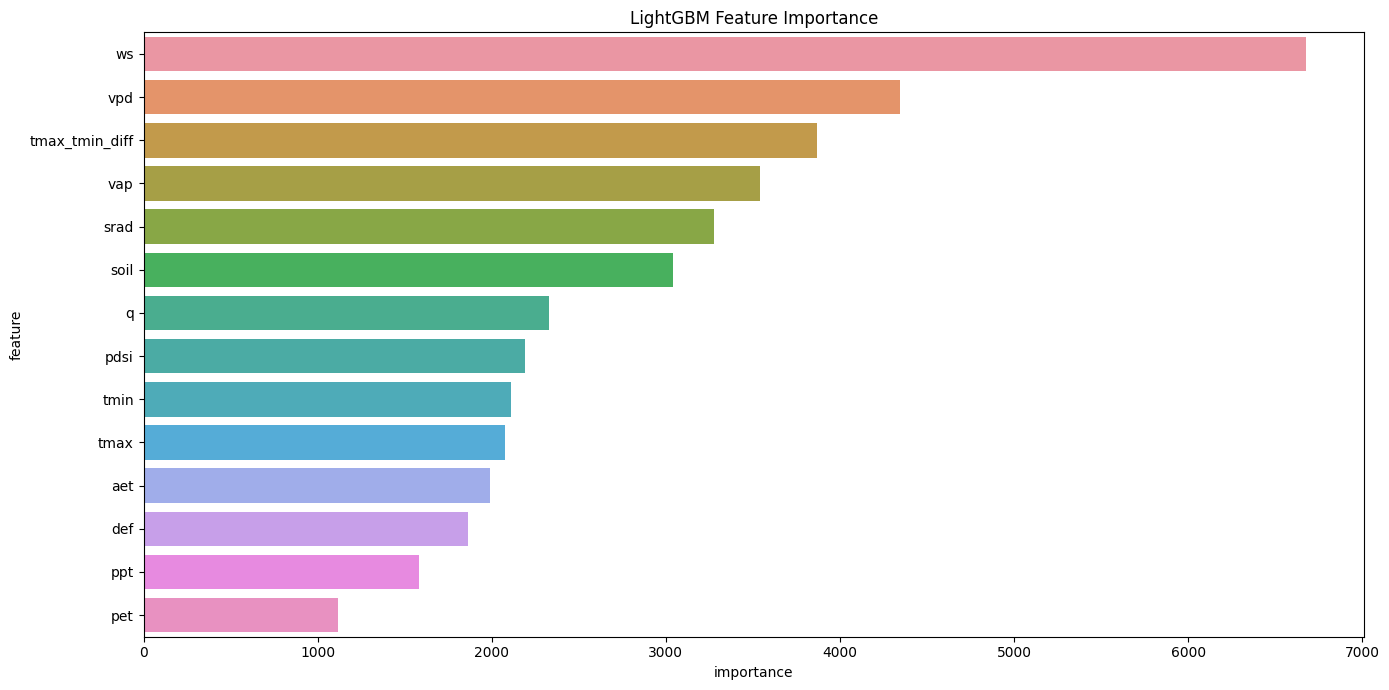

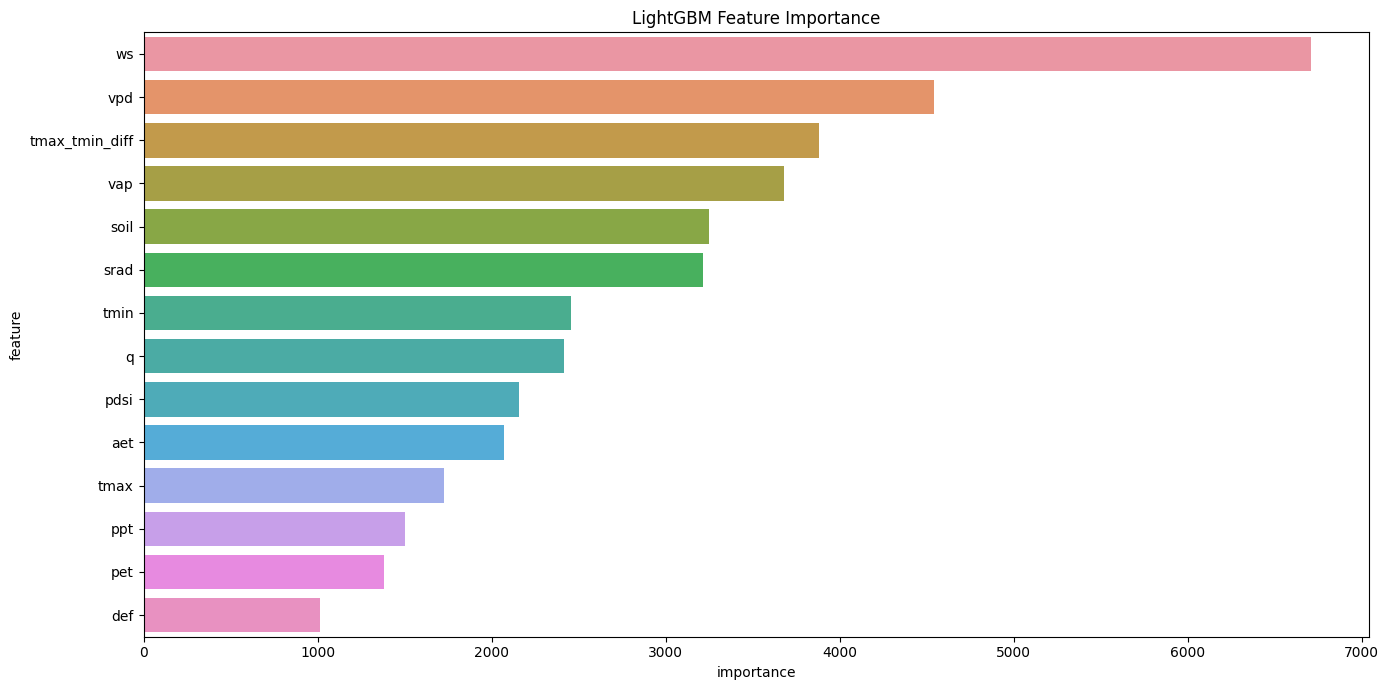

In [ ]:
from sklearn.model_selection import KFold
import lightgbm as lgb

# Convert X_train and y_train to numpy arrays
X_train_array = X_train.values
y_train_array = y_train.values

# Get the list of feature names
feature_names = X_train.columns.tolist()

# using k folds method to train 5 different models on the training dataset
kf = KFold(n_splits=5, shuffle=False)
models = []

for train_index, test_index in kf.split(X_train_array):
    train_features = X_train_array[train_index]
    train_target = y_train_array[train_index]

    test_features = X_train_array[test_index]
    test_target = y_train_array[test_index]

    d_training = lgb.Dataset(train_features, label=train_target, free_raw_data=False, feature_name=feature_names)
    d_test = lgb.Dataset(test_features, label=test_target, free_raw_data=False, feature_name=feature_names)

    model = lgb.train(opti_params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training, d_test])
    models.append(model)

for model in models:
    df_fimp = pd.DataFrame()
    df_fimp["feature"] = feature_names
    df_fimp["importance"] = model.feature_importance()
    plt.figure(figsize=(14, 7))
    sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
    plt.title("LightGBM Feature Importance")
    plt.tight_layout()
    plt.show()  # Show the plot for each model


In [ ]:
# using average of each individual model to predict over test dataset
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(X_test, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(X_test, num_iteration=model.best_iteration)) / len(models)

### XGBoost Implementation and tuning

In [ ]:

# Define the numerical features
Numerical_features = ['aet', 'def', 'pdsi', 'pet', 'ppt', 'q', 'soil', 'srad', 'tmax', 'tmin',
                      'vap', 'vpd', 'ws', 'tmax_tmin_diff']

# Create a pipeline for numerical features preprocessing
num_tf = Pipeline([('scaler', MinMaxScaler())])

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    [('num', num_tf, Numerical_features)],
    remainder='drop'
)

# Create an XGBoost Regressor instance
XGB_re = XGBRegressor(random_state=1)

# Define the parameter grid for tuning
params = {
    'max_depth': [3, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],

}

# Create a cross-validation splitter suitable for regression
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Perform GridSearchCV for hyperparameter tuning
hypxgb = GridSearchCV(XGB_re, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
hypxgb.fit(X_train, y_train)
y_predhypxgb = hypxgb.predict(X_test)

print('The best CV parameters:', hypxgb.best_params_)
print('Best CV score:', hypxgb.best_score_)

mse = mean_squared_error(y_test, y_predhypxgb)
mae = mean_absolute_error(y_test, y_predhypxgb)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

In [ ]:
from sklearn.externals import joblib  # Import joblib for model serialization

# Define the path where you want to save the tuned model
save_path = '/content/drive/MyDrive/Dissertation/XGBoost'

# Specify the filename for the saved model
model_filename = save_path + 'tuned_xgboost_model.pkl'

# Save the tuned model to a file using a context manager
with open(model_filename, 'wb') as model_file:
    joblib.dump(hypxgb.best_estimator_, model_file)

print('Tuned XGBoost model saved to', model_filename)

### MLP Model Implementation

In [ ]:
def mlp_builder(hp):

  model = Sequential()

  # Choose the activation function.
  hp_activation_function = hp.Choice('activation_function', values=['relu', 'tanh'])

  # Add the input layer.
  model.add(Dense(hp.Int('units_1', min_value=16, max_value=128, step=16),
                  activation=hp_activation_function,
                  input_shape=(X_train_mm.shape[1],)))

  # Add hidden layers.
  for i in range(hp.Int("num_layers", 1, 3)):
    model.add(Dense(hp.Int(f"units_{i}", min_value=16, max_value=128, step=16),
                   activation=hp_activation_function))  # Use hp_activation_function here

  # Add the output layer.
  model.add(Dense(1))

  # Compile the model.
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01, clipnorm=1.), loss='mae')

  return model

# Rest of your code remains the same


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,
                                               restore_best_weights=True,
                                               mode='min')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Dissertation')  # Replace with the actual path


In [ ]:
# MLP model tuner
drive_path = '/content/drive/MyDrive/Dissertation'
tuner = kt.Hyperband(mlp_builder,
                     objective='val_loss',
                     max_epochs=100,
                     directory='my_dir',
                     project_name='mlp_final')
# search for the optimal hyperparameters for MLP
tuner.search(X_train_mm, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early, tensorboard], shuffle=False)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the last densely-connected
layer is {best_hps.get('units_1')}, while the optimal number of nodes for the first hidden layer
is {best_hps.get('units_0')}. The activation function for the hidden layers is {best_hps.get('activation_function')}
The number of layers is {best_hps.get('num_layers')}.
""")


In [ ]:
# Retraining the model using optimal hyperparameters on the entire training set
MLP_model = mlp_builder(best_hps)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,
                                               restore_best_weights=True,
                                              mode='min')
checkpoint_mlp = tf.keras.callbacks.ModelCheckpoint("MLP_mode1.h5")
MLP_model.fit(x=X_train_mm, y=y_train, epochs=100, callbacks=[stop_early, checkpoint_mlp])

# Save the model to the drive path.
MLP_model.save(f'{drive_path}/MLP_model1.h5')


In [ ]:
# Get the top model
MLP_model = tuner.get_best_models(num_models=1)[0]
MLP_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                240       
                                                                 
 dense_1 (Dense)             (None, 112)               1904      
                                                                 
 dense_2 (Dense)             (None, 1)                 113       
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


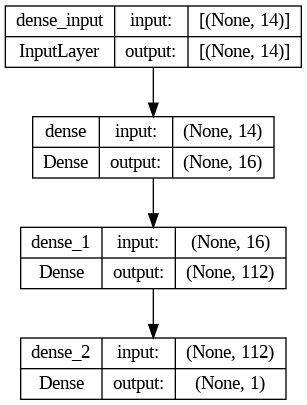

In [ ]:
from keras.utils.vis_utils import plot_model

# Plot the model.
plot_model(MLP_model, to_file=f'{drive_path}/MLP_model1.png', show_shapes=True, show_layer_names=True)


### Predictions on Unseen Data

Now that we have validated our model, we will use it to make predictions for a set of test coordinates provided for the challenge. The coordinates are found in the 'level_3_test_data.csv' file.

In [ ]:
# loading test data
test_df = pd.read_csv("./level_3_test_data.csv")

In [ ]:
# Checking the shape of the submission template
test_df.shape

(182, 6)

In [ ]:
# Displaying the first 5 rows of the submission template
test_df.head()

,Id,min_lon,min_lat,max_lon,max_lat,Predicted_frog_count
0,1,133.9014,-27.1322,134.1738,-26.8813,NaN
1,2,134.1738,-32.9015,134.4463,-32.6506,NaN
2,3,134.9912,-32.9015,135.2637,-32.6506,NaN
3,4,135.2637,-34.6574,135.5361,-34.4065,NaN
4,5,135.2637,-34.1557,135.5361,-33.9048,NaN


In [ ]:
# Generating the bbox grid for Australia, South Africa and Costa Rica
def test_country_bbox(country, lat_km, lon_km):
    '''This function will return n number of bbox grid for the give country. The Area of the bbox will be approximatly 25 km2'''
    if country.lower() == "test_aus":
        aus_whole = {"min_lati":test_df.iloc[:80,2].min(),"max_lati":test_df.iloc[:80,4].max(),"min_longi":test_df.iloc[:80,1].min(),"max_longi":test_df.iloc[:80,3].max()}
    elif country.lower() == "test_sa":
        aus_whole = {"min_lati":test_df.iloc[80:154,2].min(),"max_lati":test_df.iloc[80:154,4].max(),"min_longi":test_df.iloc[80:154,1].min(),"max_longi":test_df.iloc[80:154,3].max()}
    elif country.lower() == "test_cr":
        aus_whole = {"min_lati":test_df.iloc[154:,2].min(),"max_lati":test_df.iloc[154:,4].max(),"min_longi":test_df.iloc[154:,1].min(),"max_longi":test_df.iloc[154:,3].max()}
    bbox_grid_whole = [({"min_x":np.round(x,4), "min_y":np.round(y,4), "max_x":np.round(x + (0.015060 * lon_km),4),
                         "max_y":np.round(y + (0.008983 * lat_km),4)}) for x, y in itertools.product(np.arange(aus_whole["min_longi"], aus_whole["max_longi"],(0.015060 * lon_km)),
                                                                                       np.arange(aus_whole["min_lati"], aus_whole["max_lati"],(0.008983 * lat_km)))]
    return bbox_grid_whole, aus_whole

Generate the bounding box and get the TerraClimate data on each of the bounding boxes

In [ ]:
# Block of the code to generate the bounding box, get the frog count and climatic variables for each of the bounding box from the TerraClimate Dataset
# This code snippet may take some time to run as it has to extract the data from the TerraClimate Dataset

lat_km = math.sqrt(25)
lon_km = math.sqrt(25)
country_list = ['test_aus', 'test_sa', 'test_cr']
time_range = [["2011-11-01","2013-11-01"], ["2013-11-01","2015-11-01"], ["2015-11-01","2017-11-01"], ["2017-11-01","2019-11-01"]]
for country in country_list:
    bbox_grid_whole, aus_whole = test_country_bbox(country, lat_km, lon_km)
    aus_whole_filt_cord_df = generate_frog_count(bbox_grid_whole)
    get_data(time_range, test_df, country, aus_whole)
print("Data Generation Complete")

Data Generation Complete


In [ ]:
test_date_ranges = ['2011to2013', '2013to2015', '2015to2017', '2017to2019']

# Combined the Test data outputs into 1 Dataframe/CSV file.
for date_range in test_date_ranges:
    file1_aus_test = pd.read_csv(fr"/step_1_output/{date_range}_Terraclimate_test_aus_grid_bbox_25sqkm_v2.csv")
    file2_sa_test = pd.read_csv(fr"/step_1_output/{date_range}_Terraclimate_test_sa_grid_bbox_25sqkm_v2.csv")
    file3_cr_test = pd.read_csv(fr"/step_1_output/{date_range}_Terraclimate_test_cr_grid_bbox_25sqkm_v2.csv")
    file1_aus_test = file1_aus_test.iloc[:80,:]
    file2_sa_test = file2_sa_test.iloc[80:154,:]
    file3_cr_test.iloc[154:,6:] = file3_cr_test.iloc[154:,6:].fillna(file3_cr_test.iloc[154:,6:].median())
    file3_cr_test = file3_cr_test.iloc[154:,:]
    final_file = file1_aus_test.append(file2_sa_test)
    final_file = final_file.append(file3_cr_test)
    final_file.reset_index(drop=True)
    final_file.to_csv(fr"./step_1_output/Terraclimate_bbox_25sqkm_test_{date_range}.csv", index=False)

XGBoost Prediction on Unseen Data

In [ ]:
terra_test = pd.read_csv("/step_1_output/Terraclimate_bbox_25sqkm_test_2017to2019.csv")
terra_test_2011 = pd.read_csv("/step_1_output/Terraclimate_bbox_25sqkm_test_2011to2013.csv")
terra_test_2013 = pd.read_csv("/step_1_output/Terraclimate_bbox_25sqkm_test_2013to2015.csv")
terra_test_2015 = pd.read_csv("/step_1_output/Terraclimate_bbox_25sqkm_test_2015to2017.csv")


In [ ]:
merged_terra_test = pd.concat([terra_test, terra_test_2011, terra_test_2013, terra_test_2015], ignore_index=True)

In [ ]:
# Filtering feature columns for the modelling.
feat_cols = merged_terra_test.columns[6:].tolist()
feat_cols.extend(["Predicted_frog_count"])
remove_cols = ["samples_count", "ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence", 'swe', 'cover_rep']
feat_cols = [i for i in feat_cols if i not in remove_cols]

XGB_Pred = merged_terra_test[feat_cols]

XGB_Pred.fillna(cr_train.median(), inplace=True)

In [ ]:
XGB_Pred["tmax_tmin_diff"] = XGB_Pred["tmax"] - XGB_Pred["tmin"]

In [ ]:
XGB_Pred.head()

,aet,def,pdsi,pet,ppt,q,soil,srad,tmax,tmin,vap,vpd,ws,Predicted_frog_count,tmax_tmin_diff
0,9.554465,193.988556,-1.315333,203.543182,10.057222,0.504778,0.000000,260.749664,30.356882,15.238997,0.761605,2.541255,3.720098,NaN,15.117885
1,24.260824,125.342743,-2.594265,149.603699,25.540000,1.276205,1.548207,225.761948,23.978258,12.189644,1.122301,1.016830,4.816955,NaN,11.788614
2,19.722441,124.768387,-2.427332,144.490799,20.750778,1.040222,1.338556,227.924530,24.816610,11.220125,0.994024,1.259458,3.419528,NaN,13.596485
3,33.215874,90.650879,-3.708822,123.866737,34.615647,1.733882,19.921053,214.367111,21.252594,12.280351,1.233284,0.680389,5.370409,NaN,8.972243
4,27.878838,103.703072,-3.431045,131.582077,29.423238,1.470381,8.049143,218.400101,22.273918,11.937435,1.176371,0.797895,4.781218,NaN,10.336483


In [ ]:
import pandas as pd
import xgboost as xgb
import joblib


# Load the saved XGBoost model
model_filename = '/content/drive/MyDrive/Dissertation/XGBoost/XGBoosttuned_xgboost_model.pkl'  # Replace with the correct path
loaded_model = joblib.load(model_filename)

# Extract the relevant features from your test data
features = ['aet', 'def', 'pdsi', 'pet', 'ppt', 'q', 'soil', 'srad', 'tmax', 'tmin', 'vap', 'vpd', 'ws', 'tmax_tmin_diff']

# Make predictions using the loaded model
predictions = loaded_model.predict(XGB_Pred[features])

# Assuming the predictions are for 'Predicted_frog_count', you can add them as a new column
XGB_Pred['Predicted_frog_count'] = predictions

# Now, merged_terra_test_f contains the original test data with the predicted frog counts
# You can save this DataFrame to a CSV file if needed


In [ ]:
# Round the 'Predicted_frog_count' column to integers
XGB_Pred['Predicted_frog_count'] = XGB_Pred['Predicted_frog_count'].round().astype(int)

# Now, 'Predicted_frog_count' contains rounded integer values


In [ ]:
XGB_Pred.head()

,aet,def,pdsi,pet,ppt,q,soil,srad,tmax,tmin,vap,vpd,ws,Predicted_frog_count,tmax_tmin_diff
0,9.554465,193.988556,-1.315333,203.543182,10.057222,0.504778,0.000000,260.749664,30.356882,15.238997,0.761605,2.541255,3.720098,2,15.117885
1,24.260824,125.342743,-2.594265,149.603699,25.540000,1.276205,1.548207,225.761948,23.978258,12.189644,1.122301,1.016830,4.816955,27,11.788614
2,19.722441,124.768387,-2.427332,144.490799,20.750778,1.040222,1.338556,227.924530,24.816610,11.220125,0.994024,1.259458,3.419528,4,13.596485
3,33.215874,90.650879,-3.708822,123.866737,34.615647,1.733882,19.921053,214.367111,21.252594,12.280351,1.233284,0.680389,5.370409,5,8.972243
4,27.878838,103.703072,-3.431045,131.582077,29.423238,1.470381,8.049143,218.400101,22.273918,11.937435,1.176371,0.797895,4.781218,16,10.336483


In [ ]:
submission = pd.read_csv(r"/content/drive/MyDrive/BWW FY22 Level3 Winner/level_3_test_data.csv")
submission['Predicted_frog_count'] = XGB_Pred['Predicted_frog_count']
submission.to_csv("/content/drive/MyDrive/Dissertation/XGBoost/XGB_Pred.csv", index=False)
submission.head()


,Id,min_lon,min_lat,max_lon,max_lat,Predicted_frog_count
0,1,133.9014,-27.1322,134.1738,-26.8813,2
1,2,134.1738,-32.9015,134.4463,-32.6506,27
2,3,134.9912,-32.9015,135.2637,-32.6506,4
3,4,135.2637,-34.6574,135.5361,-34.4065,5
4,5,135.2637,-34.1557,135.5361,-33.9048,16


MLP Predictions on Unseen Data

In [ ]:
# Filtering feature columns for the modelling.
feat_cols = merged_terra_test.columns[6:].tolist()
feat_cols.extend(["Predicted_frog_count"])
remove_cols = ["samples_count", "ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence", 'swe', 'cover_rep']
feat_cols = [i for i in feat_cols if i not in remove_cols]

NN_Pred = merged_terra_test[feat_cols]

NN_Pred.fillna(cr_train.median(), inplace=True)

NN_Pred["tmax_tmin_diff"] = NN_Pred["tmax"] - NN_Pred["tmin"]
NN_Pred.head()

,aet,def,pdsi,pet,ppt,q,soil,srad,tmax,tmin,vap,vpd,ws,Predicted_frog_count,tmax_tmin_diff
0,9.554465,193.988556,-1.315333,203.543182,10.057222,0.504778,0.000000,260.749664,30.356882,15.238997,0.761605,2.541255,3.720098,NaN,15.117885
1,24.260824,125.342743,-2.594265,149.603699,25.540000,1.276205,1.548207,225.761948,23.978258,12.189644,1.122301,1.016830,4.816955,NaN,11.788614
2,19.722441,124.768387,-2.427332,144.490799,20.750778,1.040222,1.338556,227.924530,24.816610,11.220125,0.994024,1.259458,3.419528,NaN,13.596485
3,33.215874,90.650879,-3.708822,123.866737,34.615647,1.733882,19.921053,214.367111,21.252594,12.280351,1.233284,0.680389,5.370409,NaN,8.972243
4,27.878838,103.703072,-3.431045,131.582077,29.423238,1.470381,8.049143,218.400101,22.273918,11.937435,1.176371,0.797895,4.781218,NaN,10.336483


In [ ]:
import tensorflow as tf
from tensorflow import keras

# Load the MLP model
mlp_model = keras.models.load_model('/content/drive/MyDrive/Dissertation/MLP_model.h5')

features = ['aet', 'def', 'pdsi', 'pet', 'ppt', 'q', 'soil', 'srad', 'tmax', 'tmin', 'vap', 'vpd', 'ws', 'tmax_tmin_diff']

# Make predictions using the loaded model
NN_Pred = NN_Pred[features]

scaler = MinMaxScaler()

# Fit and transform the DataFrame using the scaler
NN_Pred_scaled = scaler.fit_transform(NN_Pred)

# Create a new DataFrame with the scaled values
NN_Pred_scaled_df = pd.DataFrame(NN_Pred_scaled, columns=NN_Pred.columns)
NN_Pred_scaled_df.head()

mlp_predictions = mlp_model.predict(NN_Pred_scaled_df)
# Round the predictions to integers
mlp_predictions_rounded = mlp_predictions.round().astype(int)

NN_Pred['Predicted_frog_count'] = mlp_predictions_rounded
# Now, 'mlp_predictions_rounded' contains the rounded integer predictions
NN_Pred.head()

23/23 [==============================] - 0s 2ms/step


,aet,def,pdsi,pet,ppt,q,soil,srad,tmax,tmin,vap,vpd,ws,tmax_tmin_diff,Predicted_frog_count
0,9.554465,193.988556,-1.315333,203.543182,10.057222,0.504778,0.000000,260.749664,30.356882,15.238997,0.761605,2.541255,3.720098,15.117885,2
1,24.260824,125.342743,-2.594265,149.603699,25.540000,1.276205,1.548207,225.761948,23.978258,12.189644,1.122301,1.016830,4.816955,11.788614,7
2,19.722441,124.768387,-2.427332,144.490799,20.750778,1.040222,1.338556,227.924530,24.816610,11.220125,0.994024,1.259458,3.419528,13.596485,3
3,33.215874,90.650879,-3.708822,123.866737,34.615647,1.733882,19.921053,214.367111,21.252594,12.280351,1.233284,0.680389,5.370409,8.972243,9
4,27.878838,103.703072,-3.431045,131.582077,29.423238,1.470381,8.049143,218.400101,22.273918,11.937435,1.176371,0.797895,4.781218,10.336483,15


In [ ]:
submission1 = pd.read_csv(r"/content/drive/MyDrive/BWW FY22 Level3 Winner/level_3_test_data.csv")
submission1['Predicted_frog_count'] = NN_Pred['Predicted_frog_count']
submission1.to_csv("/content/drive/MyDrive/Dissertation/MLP1/NN_Pred.csv", index=False)
submission.head()

,Id,min_lon,min_lat,max_lon,max_lat,Predicted_frog_count
0,1,133.9014,-27.1322,134.1738,-26.8813,2
1,2,134.1738,-32.9015,134.4463,-32.6506,27
2,3,134.9912,-32.9015,135.2637,-32.6506,4
3,4,135.2637,-34.6574,135.5361,-34.4065,5
4,5,135.2637,-34.1557,135.5361,-33.9048,16


### Visualizing the Predictions

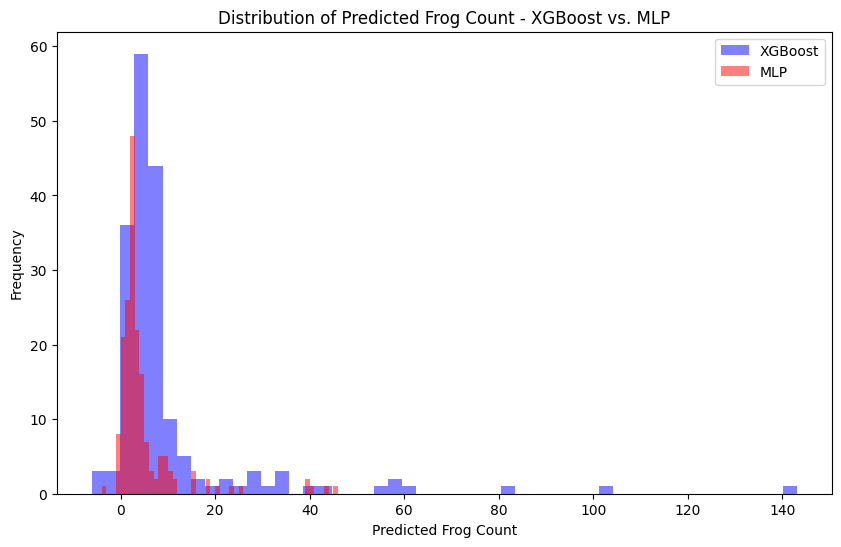

In [ ]:
import pandas as pd

# Define the file paths
xgb_pred_path = '/content/drive/MyDrive/Dissertation/XGBoost/XGB_Pred.csv'
nn_pred_path = '/content/drive/MyDrive/Dissertation/MLP1/NN_Pred.csv'

# Load the CSV files into DataFrames
XGB_Pred = pd.read_csv(xgb_pred_path)
NN_Pred = pd.read_csv(nn_pred_path)

import matplotlib.pyplot as plt



# Plot the distribution of predicted frog count for XGBoost
plt.figure(figsize=(10, 6))
plt.hist(XGB_Pred['Predicted_frog_count'], bins=50, alpha=0.5, label='XGBoost', color='blue')

# Plot the distribution of predicted frog count for MLP
plt.hist(NN_Pred['Predicted_frog_count'], bins=50, alpha=0.5, label='MLP', color='red')

# Add labels and a legend
plt.xlabel('Predicted Frog Count')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Distribution of Predicted Frog Count - XGBoost vs. MLP')

# Show the plot
plt.show()


In [ ]:
import folium
import pandas as pd

# Load the XGB_Pred and NN_Pred datasets
xgb_pred = pd.read_csv('/content/drive/MyDrive/Dissertation/XGBoost/XGB_Pred.csv')
nn_pred = pd.read_csv('/content/drive/MyDrive/Dissertation/MLP1/NN_Pred.csv')

In [ ]:
import folium
import pandas as pd

# Load the XGB_Pred and NN_Pred datasets
xgb_pred = pd.read_csv('/content/drive/MyDrive/Dissertation/XGBoost/XGB_Pred.csv')
nn_pred = pd.read_csv('/content/drive/MyDrive/Dissertation/MLP1/NN_Pred.csv')

# Create a map centered around a region (you can adjust the coordinates and zoom level)
m_xgb = folium.Map(location=[-25, 130], zoom_start=4)
m_nn = folium.Map(location=[-25, 130], zoom_start=4)

# Define a color scale for frog population density (you can adjust the colors)
color_scale = folium.LinearColormap(['blue', 'green', 'yellow', 'red'], vmin=min(xgb_pred['Predicted_frog_count'].min(), nn_pred['Predicted_frog_count'].min()), vmax=max(xgb_pred['Predicted_frog_count'].max(), nn_pred['Predicted_frog_count'].max()))

# Loop through each row in the XGB_Pred and NN_Pred datasets and add a marker for each prediction
for index, row in xgb_pred.iterrows():
    folium.CircleMarker(
        location=[(row['min_lat'] + row['max_lat']) / 2, (row['min_lon'] + row['max_lon']) / 2],
        radius=5,
        color='blue',
        fill=True,
        fill_color=color_scale(row['Predicted_frog_count']),  # Use the color scale based on predicted count
        fill_opacity=0.6,
        popup=f"Predicted Count (XGB): {row['Predicted_frog_count']}",
    ).add_to(m_xgb)

for index, row in nn_pred.iterrows():
    folium.CircleMarker(
        location=[(row['min_lat'] + row['max_lat']) / 2, (row['min_lon'] + row['max_lon']) / 2],
        radius=5,
        color='red',
        fill=True,
        fill_color=color_scale(row['Predicted_frog_count']),  # Use the color scale based on predicted count
        fill_opacity=0.6,
        popup=f"Predicted Count (NN): {row['Predicted_frog_count']}",
    ).add_to(m_nn)

# Add the color scale to the map
color_scale.add_to(m_xgb)
color_scale.add_to(m_nn)

# Save the maps as HTML files
m_xgb.save('/content/drive/MyDrive/Dissertation/XGBoost/XGB_Pred_Map1.html')
m_nn.save('/content/drive/MyDrive/Dissertation/MLP1/NN_Pred_Map1.html')




### Tesnorboard Graphs for evaluating NN performance

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/Dissertation/MLP1
